# Multirotor co-design with FAST-OAD

FAST-OAD is a framework for performing rapid Overall Aircraft Design co-developped by ONERA and ISAE-SUPAERO. The computational core of FAST-OAD is based on the  [OpenMDAO framework](https://openmdao.org/).

## 1. Setting up and analyzing the initial problem

To organize our work, we propose to use two user folders `data/` and `workdir/`. For instance, in `data/` we store a XML file which describes the [CeRAS reference case](http://ceras.ilr.rwth-aachen.de/trac/wiki/CeRAS/AircraftDesigns/CSR01). In `workdir/`, we store files generated or modified by FAST-OAD.

In [2]:
import os
import os.path as pth
import openmdao.api as om
from fastoad import api
import logging
from fastoad.utils.postprocessing import VariableViewer
import shutil
from models.register import register_openmdao_systems
from models.trajectory import plot_trajectory
register_openmdao_systems()
DATA_FOLDER_PATH = 'data'

WORK_FOLDER_PATH = 'workdir'

CONFIGURATION_FILE = pth.join(DATA_FOLDER_PATH,'multirotor.toml')
REF_INPUT_FILE = pth.join(DATA_FOLDER_PATH,'problem_inputs_ref.xml')
# For having log messages on screen
logging.basicConfig(level=logging.INFO, format='%(levelname)-8s: %(message)s')

# For using all screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

Unable to import mpi4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.


After defining a configuration file name, we can ask FAST-OAD to generate a default configuration file based on the default OAD model implemented in the framework:

In this configuration file, we have specified an input file name 'problem_inputs.xml'. We can ask FAST-OAD to generate the inputs of the default model with the CeRAS parameters as default values:

In [2]:
api.generate_inputs(CONFIGURATION_FILE, REF_INPUT_FILE, overwrite=True)

INFO    : Problem inputs written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\problem_inputs.xml


You can now checkout the generated [input file](./workdir/problem_inputs.xml). As shown previously in the user file architecture, the values in this file can be modified by the user and will be considered by FAST-OAD when executing a computational process.

A useful feature that FAST-OAD provides is to list the outputs of the model defined in the configuration file:

In [3]:
api.list_variables(CONFIGURATION_FILE)

,I/O,Name,Description
0,IN,data:battery:capacity:discharge_limit,
1,IN,data:battery:cell:voltage,
2,IN,data:battery:energy:ref,
3,IN,data:battery:mass:k,
4,IN,data:battery:mass:ref,
5,IN,data:battery:voltage:k,
6,IN,data:esc:efficiency,
7,IN,data:esc:mass:ref,
8,IN,data:esc:power:ref,
9,IN,data:frame:arm:density,


Another useful feature is to list the modules of the model defined in the configuration file:

In [4]:
api.list_systems(CONFIGURATION_FILE)

== AVAILABLE SYSTEM IDENTIFIERS ====================================================================
----------------------------------------------------------------------------------------------------
  IDENTIFIER:   fastoad.aerodynamics.highspeed.legacy
  PATH:         d:\users\s.delbecq\appdata\local\programs\miniconda3\lib\site-packages\fastoad\models\aerodynamics\aerodynamics_high_speed.py
  DOMAIN:       Aerodynamics
  DESCRIPTION:  
    Computes aerodynamic polar of the aircraft in cruise conditions.

    Drag contributions of each part of the aircraft are computed though analytical
    models.

----------------------------------------------------------------------------------------------------
  IDENTIFIER:   fastoad.aerodynamics.landing.legacy
  PATH:         d:\users\s.delbecq\appdata\local\programs\miniconda3\lib\site-packages\fastoad\models\aerodynamics\aerodynamics_landing.py
  DOMAIN:       Aerodynamics
  DESCRIPTION:  
    Computes aerodynamic characteristics at landing.

Another useful feature is the [N2 diagram](http://openmdao.org/twodocs/versions/latest/basic_guide/make_n2.html) visualization available in OpenMDAO to see the structure of the model:

In [5]:
N2_FILE = pth.join(WORK_FOLDER_PATH, 'n2.html')
api.write_n2(CONFIGURATION_FILE, N2_FILE, overwrite=True)
from IPython.display import IFrame
IFrame(src=N2_FILE, width='100%', height='500px')

INFO    : N2 diagram written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\n2.html


Alternatively, you can create a [WhatsOpt](https://github.com/OneraHub/WhatsOpt-Doc#whatsopt-documentation) account to generate the XDSM of the problem. If your account is created, you may uncomment next lines and run them (this should take ~ 1 min):

In [6]:
# XDSM_FILE = pth.join(WORK_FOLDER_PATH, 'xdsm.html')
# api.write_xdsm(CONFIGURATION_FILE, XDSM_FILE, overwrite=True)
# from IPython.display import IFrame
# IFrame(src=XDSM_FILE, width='100%', height='500px')

## 2. Running your first MDA

### CeRAS
Here we run an MDA, that is solving the multidisciplinary couplings using the different nested solvers in the model, without running the optimization problem even if it is defined in the configuration file.

In [6]:
INPUT_FILE = pth.join(WORK_FOLDER_PATH, 'problem_inputs.xml')
api.variable_viewer(INPUT_FILE)

In [7]:
eval_problem = api.evaluate_problem(CONFIGURATION_FILE, overwrite=True)

INFO    : Computation finished after 0.11 seconds
INFO    : Problem outputs written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\problem_outputs.xml


Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.023996700000001425 seconds.


Let's save these results. We will use them in the next workbook, that shows some post-processing utilities.

In [8]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, 'problem_outputs.xml')

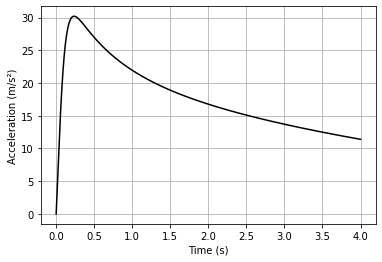

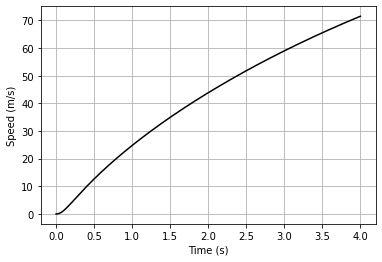

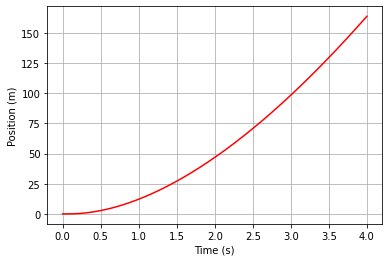

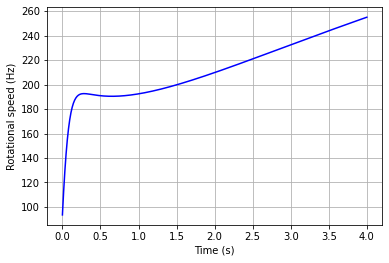

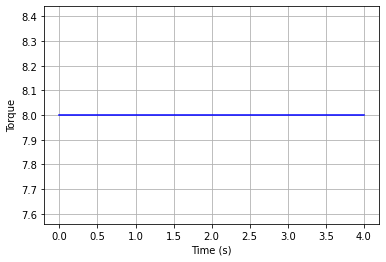

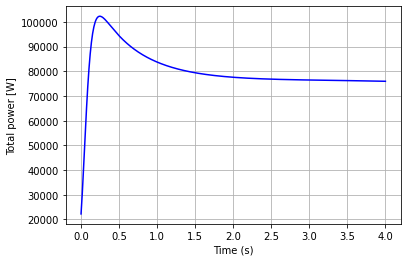

In [9]:
plot_trajectory(eval_problem.model.trajectory.trajectory.res)

The `variable-viewer` provides a way to inspect the content of the XML file. The dropdown lists above the table allow to filter the displayed variable.

In [10]:
api.variable_viewer(OUTPUT_FILE)

## 3. Running your first MDO

## CeRAS 2750 nm optimization

As seen earlier, the current aircraft configuration is estimated as unstable. We will fix this using a simple optimization problem that will move wing position so the static margin is at least +5%, while keeping the fuel consumption as low as possible. 

The default configuration file defines this optimization problem that aims at:
- minimizing the fuel consumption for the mission (objective),
- with respect to the wing position (design variables),
- subject to a static margin (constraints).

*(This run should take a few dozen seconds)*

To visualize and edit the optimization problem definition (present in the configuration file .toml) you can use the `optimization_viewer` tool. If design variables or constraints have active bounds they are yellow whereas they are red if they are violated. Modifiying the `Initial Value` will modify the input file defined in the configuration file .toml whereas `Value` corresponds to the value found in the output file defined in the configuration file (here it is the 800 nm MDA run).

In [11]:
api.optimization_viewer(CONFIGURATION_FILE)

In [3]:
optim_problem = api.optimize_problem(CONFIGURATION_FILE, overwrite=True)

Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.018680999999997283 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.0185651 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.019809399999999755 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.01870320000000092 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.01830680000000129 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.018243699999999308 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.01902329999999708 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.018004300000001194 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.0179679999999997

Simulation interval    : 0.0 - 3.986299670367458 seconds.
Elapsed simulation time: 0.018610600000002364 seconds.
Simulation interval    : 0.0 - 3.986299670367458 seconds.
Elapsed simulation time: 0.018880499999994527 seconds.
Simulation interval    : 0.0 - 3.986299670367458 seconds.
Elapsed simulation time: 0.01828800000000541 seconds.
Simulation interval    : 0.0 - 3.986299670367458 seconds.
Elapsed simulation time: 0.01849070000000097 seconds.
Simulation interval    : 0.0 - 3.986299670367458 seconds.
Elapsed simulation time: 0.01850910000000283 seconds.
Simulation interval    : 0.0 - 3.986299670367458 seconds.
Elapsed simulation time: 0.01847389999999649 seconds.
Simulation interval    : 0.0 - 3.945179955428095 seconds.
Elapsed simulation time: 0.01824009999999987 seconds.
Simulation interval    : 0.0 - 3.945179955428095 seconds.
Elapsed simulation time: 0.018658000000002062 seconds.
Simulation interval    : 0.0 - 3.945179955428095 seconds.
Elapsed simulation time: 0.0192109000000044

Simulation interval    : 0.0 - 3.8774782016712916 seconds.
Elapsed simulation time: 0.01851149999999535 seconds.
Simulation interval    : 0.0 - 3.8774782016712916 seconds.
Elapsed simulation time: 0.018671600000004673 seconds.
Simulation interval    : 0.0 - 3.8774782016712916 seconds.
Elapsed simulation time: 0.01851870000000133 seconds.
Simulation interval    : 0.0 - 3.8774782016712916 seconds.
Elapsed simulation time: 0.019660699999995757 seconds.
Simulation interval    : 0.0 - 3.8774782016712916 seconds.
Elapsed simulation time: 0.018406800000001056 seconds.
Simulation interval    : 0.0 - 3.8774782016712916 seconds.
Elapsed simulation time: 0.019040499999995575 seconds.
Simulation interval    : 0.0 - 3.8774782016712916 seconds.
Elapsed simulation time: 0.018404600000003768 seconds.
Simulation interval    : 0.0 - 3.8774782016712916 seconds.
Elapsed simulation time: 0.01947930000000042 seconds.
Simulation interval    : 0.0 - 3.8774782016712916 seconds.
Elapsed simulation time: 0.01864

Simulation interval    : 0.0 - 3.4527648511397406 seconds.
Elapsed simulation time: 0.018279300000003218 seconds.
Simulation interval    : 0.0 - 3.452763851139741 seconds.
Elapsed simulation time: 0.01963010000000054 seconds.
Simulation interval    : 0.0 - 3.452763851139741 seconds.
Elapsed simulation time: 0.01946739999999636 seconds.
Simulation interval    : 0.0 - 3.452763851139741 seconds.
Elapsed simulation time: 0.018660699999998087 seconds.
Simulation interval    : 0.0 - 3.452763851139741 seconds.
Elapsed simulation time: 0.0193027999999984 seconds.
Simulation interval    : 0.0 - 3.452763851139741 seconds.
Elapsed simulation time: 0.018642899999996132 seconds.
Simulation interval    : 0.0 - 3.452763851139741 seconds.
Elapsed simulation time: 0.018372399999996958 seconds.
Simulation interval    : 0.0 - 3.452763851139741 seconds.
Elapsed simulation time: 0.020013599999998632 seconds.
Simulation interval    : 0.0 - 3.452763851139741 seconds.
Elapsed simulation time: 0.01975890000000

Simulation interval    : 0.0 - 2.4779069728865397 seconds.
Elapsed simulation time: 0.019364899999999352 seconds.
Simulation interval    : 0.0 - 2.4779069728865397 seconds.
Elapsed simulation time: 0.01805360000000178 seconds.
Simulation interval    : 0.0 - 2.4779079728865394 seconds.
Elapsed simulation time: 0.01804880000000253 seconds.
Simulation interval    : 0.0 - 2.4779069728865397 seconds.
Elapsed simulation time: 0.018222099999995578 seconds.
Simulation interval    : 0.0 - 2.4779069728865397 seconds.
Elapsed simulation time: 0.018619700000002126 seconds.
Simulation interval    : 0.0 - 2.4779069728865397 seconds.
Elapsed simulation time: 0.018099800000001665 seconds.
Simulation interval    : 0.0 - 2.4779069728865397 seconds.
Elapsed simulation time: 0.018564800000000048 seconds.
Simulation interval    : 0.0 - 2.4779069728865397 seconds.
Elapsed simulation time: 0.018905400000001293 seconds.
Simulation interval    : 0.0 - 2.4779069728865397 seconds.
Elapsed simulation time: 0.0184

Simulation interval    : 0.0 - 2.3030595029829812 seconds.
Elapsed simulation time: 0.019649499999999875 seconds.
Simulation interval    : 0.0 - 2.3030595029829812 seconds.
Elapsed simulation time: 0.019033700000001375 seconds.
Simulation interval    : 0.0 - 2.3030595029829812 seconds.
Elapsed simulation time: 0.0185569000000001 seconds.
Simulation interval    : 0.0 - 2.3030595029829812 seconds.
Elapsed simulation time: 0.019138800000000344 seconds.
Simulation interval    : 0.0 - 2.3030595029829812 seconds.
Elapsed simulation time: 0.018855100000003233 seconds.
Simulation interval    : 0.0 - 2.3030595029829812 seconds.
Elapsed simulation time: 0.018280499999995925 seconds.
Simulation interval    : 0.0 - 2.3030595029829812 seconds.
Elapsed simulation time: 0.01888929999999789 seconds.
Simulation interval    : 0.0 - 2.3030595029829812 seconds.
Elapsed simulation time: 0.01856979999999453 seconds.
Simulation interval    : 0.0 - 2.3030595029829812 seconds.
Elapsed simulation time: 0.018365

Simulation interval    : 0.0 - 2.3648338426888156 seconds.
Elapsed simulation time: 0.018924200000000724 seconds.
Simulation interval    : 0.0 - 2.3648338426888156 seconds.
Elapsed simulation time: 0.01880119999999863 seconds.
Simulation interval    : 0.0 - 2.3648338426888156 seconds.
Elapsed simulation time: 0.018519799999999975 seconds.
Simulation interval    : 0.0 - 2.3648338426888156 seconds.
Elapsed simulation time: 0.018370699999998408 seconds.
Simulation interval    : 0.0 - 2.3648338426888156 seconds.
Elapsed simulation time: 0.018613899999998296 seconds.
Simulation interval    : 0.0 - 2.3648338426888156 seconds.
Elapsed simulation time: 0.01887580000000355 seconds.
Simulation interval    : 0.0 - 2.5190778724005964 seconds.
Elapsed simulation time: 0.018677099999997893 seconds.
Simulation interval    : 0.0 - 2.3907019352081837 seconds.
Elapsed simulation time: 0.01833260000000081 seconds.
Simulation interval    : 0.0 - 2.370006770550648 seconds.
Elapsed simulation time: 0.019425

Simulation interval    : 0.0 - 2.41486375009381 seconds.
Elapsed simulation time: 0.02393769999999762 seconds.
Simulation interval    : 0.0 - 2.41486375009381 seconds.
Elapsed simulation time: 0.01910790000000162 seconds.
Simulation interval    : 0.0 - 2.41486375009381 seconds.
Elapsed simulation time: 0.01889320000000083 seconds.
Simulation interval    : 0.0 - 2.41486375009381 seconds.
Elapsed simulation time: 0.01902669999999773 seconds.
Simulation interval    : 0.0 - 2.41486375009381 seconds.
Elapsed simulation time: 0.019279699999998456 seconds.
Simulation interval    : 0.0 - 2.41486375009381 seconds.
Elapsed simulation time: 0.018701399999997648 seconds.
Simulation interval    : 0.0 - 2.41486375009381 seconds.
Elapsed simulation time: 0.018526699999995344 seconds.
Simulation interval    : 0.0 - 2.41486375009381 seconds.
Elapsed simulation time: 0.01921910000000082 seconds.
Simulation interval    : 0.0 - 2.41486375009381 seconds.
Elapsed simulation time: 0.018639499999999032 second

Simulation interval    : 0.0 - 2.713352741885205 seconds.
Elapsed simulation time: 0.020835499999996898 seconds.
Simulation interval    : 0.0 - 2.4618192373136787 seconds.
Elapsed simulation time: 0.020572600000001273 seconds.
Simulation interval    : 0.0 - 2.4618192373136787 seconds.
Elapsed simulation time: 0.03933109999999829 seconds.
Simulation interval    : 0.0 - 2.4618192373136787 seconds.
Elapsed simulation time: 0.01931640000000101 seconds.
Simulation interval    : 0.0 - 2.4618192373136787 seconds.
Elapsed simulation time: 0.018712999999998203 seconds.
Simulation interval    : 0.0 - 2.4618192373136787 seconds.
Elapsed simulation time: 0.019198799999998073 seconds.
Simulation interval    : 0.0 - 2.4618192373136787 seconds.
Elapsed simulation time: 0.01809400000000494 seconds.
Simulation interval    : 0.0 - 2.4618192373136787 seconds.
Elapsed simulation time: 0.01855160000000211 seconds.
Simulation interval    : 0.0 - 2.4618192373136787 seconds.
Elapsed simulation time: 0.0184631

Simulation interval    : 0.0 - 2.5333099883061614 seconds.
Elapsed simulation time: 0.019097999999999615 seconds.
Simulation interval    : 0.0 - 2.5333099883061614 seconds.
Elapsed simulation time: 0.018952699999999822 seconds.
Simulation interval    : 0.0 - 2.5333099883061614 seconds.
Elapsed simulation time: 0.0186238000000003 seconds.
Simulation interval    : 0.0 - 2.5333099883061614 seconds.
Elapsed simulation time: 0.018336300000001415 seconds.
Simulation interval    : 0.0 - 2.5333099883061614 seconds.
Elapsed simulation time: 0.018075600000003078 seconds.
Simulation interval    : 0.0 - 2.5333099883061614 seconds.
Elapsed simulation time: 0.01874480000000034 seconds.
Simulation interval    : 0.0 - 2.5333099883061614 seconds.
Elapsed simulation time: 0.018459000000000003 seconds.
Simulation interval    : 0.0 - 2.5333099883061614 seconds.
Elapsed simulation time: 0.01856730000000084 seconds.
Simulation interval    : 0.0 - 3.02874041137241 seconds.
Elapsed simulation time: 0.01845959

Simulation interval    : 0.0 - 2.55852577569701 seconds.
Elapsed simulation time: 0.019048399999995524 seconds.
Simulation interval    : 0.0 - 2.55852577569701 seconds.
Elapsed simulation time: 0.01844220000000263 seconds.
Simulation interval    : 0.0 - 2.5585267756970103 seconds.
Elapsed simulation time: 0.01884030000000081 seconds.
Simulation interval    : 0.0 - 2.55852577569701 seconds.
Elapsed simulation time: 0.020133700000002364 seconds.
Simulation interval    : 0.0 - 2.55852577569701 seconds.
Elapsed simulation time: 0.01835930000000019 seconds.
Simulation interval    : 0.0 - 2.55852577569701 seconds.
Elapsed simulation time: 0.018378400000003126 seconds.
Simulation interval    : 0.0 - 2.55852577569701 seconds.
Elapsed simulation time: 0.018239899999997533 seconds.
Simulation interval    : 0.0 - 2.55852577569701 seconds.
Elapsed simulation time: 0.018416600000001893 seconds.
Simulation interval    : 0.0 - 2.55852577569701 seconds.
Elapsed simulation time: 0.01866730000000416 sec

Simulation interval    : 0.0 - 2.70862714783497 seconds.
Elapsed simulation time: 0.01899840000000097 seconds.
Simulation interval    : 0.0 - 2.674936301449675 seconds.
Elapsed simulation time: 0.019140499999998895 seconds.
Simulation interval    : 0.0 - 2.674936301449675 seconds.
Elapsed simulation time: 0.019773100000001875 seconds.
Simulation interval    : 0.0 - 2.674936301449675 seconds.
Elapsed simulation time: 0.018311699999998154 seconds.
Simulation interval    : 0.0 - 2.674936301449675 seconds.
Elapsed simulation time: 0.018618599999996377 seconds.
Simulation interval    : 0.0 - 2.674936301449675 seconds.
Elapsed simulation time: 0.01920340000000209 seconds.
Simulation interval    : 0.0 - 2.674936301449675 seconds.
Elapsed simulation time: 0.022872700000000634 seconds.
Simulation interval    : 0.0 - 2.674936301449675 seconds.
Elapsed simulation time: 0.018158799999994812 seconds.
Simulation interval    : 0.0 - 2.674936301449675 seconds.
Elapsed simulation time: 0.01844659999999

Elapsed simulation time: 0.01854609999999468 seconds.
Simulation interval    : 0.0 - 2.687414174456814 seconds.
Elapsed simulation time: 0.01854399999999856 seconds.
Simulation interval    : 0.0 - 2.687414174456814 seconds.
Elapsed simulation time: 0.018687700000000973 seconds.
Simulation interval    : 0.0 - 2.687414174456814 seconds.
Elapsed simulation time: 0.019668500000001643 seconds.
Simulation interval    : 0.0 - 2.687414174456814 seconds.
Elapsed simulation time: 0.018391200000003494 seconds.
Simulation interval    : 0.0 - 2.687414174456814 seconds.
Elapsed simulation time: 0.018837800000000016 seconds.
Simulation interval    : 0.0 - 2.687414174456814 seconds.
Elapsed simulation time: 0.018053700000002948 seconds.
Simulation interval    : 0.0 - 2.687414174456814 seconds.
Elapsed simulation time: 0.019135900000001982 seconds.
Simulation interval    : 0.0 - 2.687414174456814 seconds.
Elapsed simulation time: 0.019261800000002438 seconds.
Simulation interval    : 0.0 - 2.6874141744

Simulation interval    : 0.0 - 2.768614783667156 seconds.
Elapsed simulation time: 0.019091700000004153 seconds.
Simulation interval    : 0.0 - 2.768615783667156 seconds.
Elapsed simulation time: 0.020965600000003803 seconds.
Simulation interval    : 0.0 - 2.768614783667156 seconds.
Elapsed simulation time: 0.021774599999993427 seconds.
Simulation interval    : 0.0 - 2.768614783667156 seconds.
Elapsed simulation time: 0.01912240000000054 seconds.
Simulation interval    : 0.0 - 2.768614783667156 seconds.
Elapsed simulation time: 0.018463500000002853 seconds.
Simulation interval    : 0.0 - 2.768614783667156 seconds.
Elapsed simulation time: 0.020528499999997507 seconds.
Simulation interval    : 0.0 - 2.768614783667156 seconds.
Elapsed simulation time: 0.019028699999999787 seconds.
Simulation interval    : 0.0 - 2.768614783667156 seconds.
Elapsed simulation time: 0.01857869999999906 seconds.
Simulation interval    : 0.0 - 2.768614783667156 seconds.
Elapsed simulation time: 0.0181605000000

Simulation interval    : 0.0 - 3.1847230962643267 seconds.
Elapsed simulation time: 0.018133499999997582 seconds.
Simulation interval    : 0.0 - 2.8637876611277973 seconds.
Elapsed simulation time: 0.019659099999998375 seconds.
Simulation interval    : 0.0 - 2.8316941176141444 seconds.
Elapsed simulation time: 0.01947020000000066 seconds.
Simulation interval    : 0.0 - 2.8316941176141444 seconds.
Elapsed simulation time: 0.018546399999998187 seconds.
Simulation interval    : 0.0 - 2.8316941176141444 seconds.
Elapsed simulation time: 0.019182800000002942 seconds.
Simulation interval    : 0.0 - 2.8316941176141444 seconds.
Elapsed simulation time: 0.018181699999999523 seconds.
Simulation interval    : 0.0 - 2.8316941176141444 seconds.
Elapsed simulation time: 0.018953700000004403 seconds.
Simulation interval    : 0.0 - 2.8316941176141444 seconds.
Elapsed simulation time: 0.018823000000004697 seconds.
Simulation interval    : 0.0 - 2.8316941176141444 seconds.
Elapsed simulation time: 0.018

Simulation interval    : 0.0 - 2.8390993359092582 seconds.
Elapsed simulation time: 0.019129700000000582 seconds.
Simulation interval    : 0.0 - 2.8390993359092582 seconds.
Elapsed simulation time: 0.018593500000001484 seconds.
Simulation interval    : 0.0 - 2.8390993359092582 seconds.
Elapsed simulation time: 0.01882789999999801 seconds.
Simulation interval    : 0.0 - 2.8390993359092582 seconds.
Elapsed simulation time: 0.018387099999998213 seconds.
Simulation interval    : 0.0 - 2.8390993359092582 seconds.
Elapsed simulation time: 0.020552799999997262 seconds.
Simulation interval    : 0.0 - 2.8390993359092582 seconds.
Elapsed simulation time: 0.01885700000000412 seconds.
Simulation interval    : 0.0 - 2.8390993359092582 seconds.
Elapsed simulation time: 0.021486900000006415 seconds.
Simulation interval    : 0.0 - 2.8390993359092582 seconds.
Elapsed simulation time: 0.01867210000000341 seconds.
Simulation interval    : 0.0 - 2.8390993359092582 seconds.
Elapsed simulation time: 0.01829

Simulation interval    : 0.0 - 2.8473323185760857 seconds.
Elapsed simulation time: 0.019286100000002193 seconds.
Simulation interval    : 0.0 - 2.8473323185760857 seconds.
Elapsed simulation time: 0.020005300000001114 seconds.
Simulation interval    : 0.0 - 2.8473323185760857 seconds.
Elapsed simulation time: 0.018412800000000118 seconds.
Simulation interval    : 0.0 - 2.8473333185760863 seconds.
Elapsed simulation time: 0.019551100000001043 seconds.
Simulation interval    : 0.0 - 2.8473323185760857 seconds.
Elapsed simulation time: 0.018527999999996325 seconds.
Simulation interval    : 0.0 - 2.8473323185760857 seconds.
Elapsed simulation time: 0.018960899999996172 seconds.
Simulation interval    : 0.0 - 2.8473323185760857 seconds.
Elapsed simulation time: 0.018974100000001215 seconds.
Simulation interval    : 0.0 - 2.8473323185760857 seconds.
Elapsed simulation time: 0.0198071000000013 seconds.
Simulation interval    : 0.0 - 2.8473323185760857 seconds.
Elapsed simulation time: 0.0194

Simulation interval    : 0.0 - 3.0637494627741018 seconds.
Elapsed simulation time: 0.021585999999999217 seconds.
Simulation interval    : 0.0 - 3.1299249990650315 seconds.
Elapsed simulation time: 0.019089299999997422 seconds.
Simulation interval    : 0.0 - 3.1299249990650315 seconds.
Elapsed simulation time: 0.019125900000005913 seconds.
Simulation interval    : 0.0 - 3.1299249990650315 seconds.
Elapsed simulation time: 0.018481900000004714 seconds.
Simulation interval    : 0.0 - 3.1299249990650315 seconds.
Elapsed simulation time: 0.018842999999996835 seconds.
Simulation interval    : 0.0 - 3.1299249990650315 seconds.
Elapsed simulation time: 0.020533300000003862 seconds.
Simulation interval    : 0.0 - 3.1299249990650315 seconds.
Elapsed simulation time: 0.01836749999999654 seconds.
Simulation interval    : 0.0 - 3.1299249990650315 seconds.
Elapsed simulation time: 0.01855839999999631 seconds.
Simulation interval    : 0.0 - 3.1299249990650315 seconds.
Elapsed simulation time: 0.0186

Simulation interval    : 0.0 - 3.0073757699880312 seconds.
Elapsed simulation time: 0.019095000000000084 seconds.
Simulation interval    : 0.0 - 3.0073757699880312 seconds.
Elapsed simulation time: 0.019383699999998782 seconds.
Simulation interval    : 0.0 - 3.0073757699880312 seconds.
Elapsed simulation time: 0.0220509999999976 seconds.
Simulation interval    : 0.0 - 3.0073757699880312 seconds.
Elapsed simulation time: 0.018391000000001156 seconds.
Simulation interval    : 0.0 - 3.0073757699880312 seconds.
Elapsed simulation time: 0.018117000000003713 seconds.
Simulation interval    : 0.0 - 3.0073757699880312 seconds.
Elapsed simulation time: 0.018319099999999366 seconds.
Simulation interval    : 0.0 - 3.0073757699880312 seconds.
Elapsed simulation time: 0.018198300000001666 seconds.
Simulation interval    : 0.0 - 3.0073757699880312 seconds.
Elapsed simulation time: 0.0187761999999978 seconds.
Simulation interval    : 0.0 - 3.0073757699880312 seconds.
Elapsed simulation time: 0.020403

Simulation interval    : 0.0 - 3.007981237724366 seconds.
Elapsed simulation time: 0.018592799999993304 seconds.
Simulation interval    : 0.0 - 3.007981237724366 seconds.
Elapsed simulation time: 0.021554300000005355 seconds.
Simulation interval    : 0.0 - 3.007981237724366 seconds.
Elapsed simulation time: 0.01928569999999752 seconds.
Simulation interval    : 0.0 - 3.0079822377243657 seconds.
Elapsed simulation time: 0.02331770000000688 seconds.
Simulation interval    : 0.0 - 3.007981237724366 seconds.
Elapsed simulation time: 0.018697299999999473 seconds.
Simulation interval    : 0.0 - 3.007981237724366 seconds.
Elapsed simulation time: 0.01878280000001098 seconds.
Simulation interval    : 0.0 - 3.007981237724366 seconds.
Elapsed simulation time: 0.01961430000000064 seconds.
Simulation interval    : 0.0 - 3.007981237724366 seconds.
Elapsed simulation time: 0.01875969999998972 seconds.
Simulation interval    : 0.0 - 3.007981237724366 seconds.
Elapsed simulation time: 0.018529200000003

Simulation interval    : 0.0 - 2.9575031327111 seconds.
Elapsed simulation time: 0.018101999999998952 seconds.
Simulation interval    : 0.0 - 2.9575031327111 seconds.
Elapsed simulation time: 0.018360899999990465 seconds.
Simulation interval    : 0.0 - 2.9575031327111 seconds.
Elapsed simulation time: 0.018660100000005286 seconds.
Simulation interval    : 0.0 - 2.9575031327111 seconds.
Elapsed simulation time: 0.018468999999996072 seconds.
Simulation interval    : 0.0 - 3.1028422069856902 seconds.
Elapsed simulation time: 0.018418199999999274 seconds.
Simulation interval    : 0.0 - 2.9720370401385594 seconds.
Elapsed simulation time: 0.018899700000005737 seconds.
Simulation interval    : 0.0 - 2.963896093168799 seconds.
Elapsed simulation time: 0.019382000000007338 seconds.
Simulation interval    : 0.0 - 2.963896093168799 seconds.
Elapsed simulation time: 0.03263289999999586 seconds.
Simulation interval    : 0.0 - 2.963896093168799 seconds.
Elapsed simulation time: 0.018633300000004738

Simulation interval    : 0.0 - 2.984706412396935 seconds.
Elapsed simulation time: 0.01963409999999044 seconds.
Simulation interval    : 0.0 - 2.984706412396935 seconds.
Elapsed simulation time: 0.018634099999999876 seconds.
Simulation interval    : 0.0 - 2.984706412396935 seconds.
Elapsed simulation time: 0.018960599999999772 seconds.
Simulation interval    : 0.0 - 2.984706412396935 seconds.
Elapsed simulation time: 0.01828949999999452 seconds.
Simulation interval    : 0.0 - 2.984706412396935 seconds.
Elapsed simulation time: 0.019024199999989833 seconds.
Simulation interval    : 0.0 - 2.984706412396935 seconds.
Elapsed simulation time: 0.018834200000000578 seconds.
Simulation interval    : 0.0 - 2.984706412396935 seconds.
Elapsed simulation time: 0.018223500000004833 seconds.
Simulation interval    : 0.0 - 2.984706412396935 seconds.
Elapsed simulation time: 0.01873930000000712 seconds.
Simulation interval    : 0.0 - 2.984706412396935 seconds.
Elapsed simulation time: 0.01837020000000

Simulation interval    : 0.0 - 2.9944461026115015 seconds.
Elapsed simulation time: 0.03159360000000788 seconds.
Simulation interval    : 0.0 - 2.9944461026115015 seconds.
Elapsed simulation time: 0.020053300000000718 seconds.
Simulation interval    : 0.0 - 2.9944461026115015 seconds.
Elapsed simulation time: 0.02269979999999805 seconds.
Simulation interval    : 0.0 - 2.9944471026115016 seconds.
Elapsed simulation time: 0.019030100000009043 seconds.
Simulation interval    : 0.0 - 2.9944461026115015 seconds.
Elapsed simulation time: 0.018555500000005054 seconds.
Simulation interval    : 0.0 - 2.9944461026115015 seconds.
Elapsed simulation time: 0.01884440000000609 seconds.
Simulation interval    : 0.0 - 2.9944461026115015 seconds.
Elapsed simulation time: 0.019073499999990418 seconds.
Simulation interval    : 0.0 - 2.9944461026115015 seconds.
Elapsed simulation time: 0.019905699999995363 seconds.
Simulation interval    : 0.0 - 2.9944461026115015 seconds.
Elapsed simulation time: 0.02087

Simulation interval    : 0.0 - 2.9932593222475625 seconds.
Elapsed simulation time: 0.02217689999999095 seconds.
Simulation interval    : 0.0 - 2.9932593222475625 seconds.
Elapsed simulation time: 0.01925749999999482 seconds.
Simulation interval    : 0.0 - 2.9932593222475625 seconds.
Elapsed simulation time: 0.01905629999998837 seconds.
Simulation interval    : 0.0 - 2.9932593222475625 seconds.
Elapsed simulation time: 0.01907860000000028 seconds.
Simulation interval    : 0.0 - 2.82914560268935 seconds.
Elapsed simulation time: 0.01813840000001221 seconds.
Simulation interval    : 0.0 - 2.9679547124610406 seconds.
Elapsed simulation time: 0.01934509999999534 seconds.
Simulation interval    : 0.0 - 2.9886103742733003 seconds.
Elapsed simulation time: 0.01917380000000435 seconds.
Simulation interval    : 0.0 - 2.9922527405035932 seconds.
Elapsed simulation time: 0.018388200000003962 seconds.
Simulation interval    : 0.0 - 2.992999362523904 seconds.
Elapsed simulation time: 0.019806499999

Simulation interval    : 0.0 - 3.024568868952954 seconds.
Elapsed simulation time: 0.019109000000000265 seconds.
Simulation interval    : 0.0 - 3.024567868952954 seconds.
Elapsed simulation time: 0.019189299999993636 seconds.
Simulation interval    : 0.0 - 3.024567868952954 seconds.
Elapsed simulation time: 0.018250899999998182 seconds.
Simulation interval    : 0.0 - 3.024567868952954 seconds.
Elapsed simulation time: 0.018767499999995607 seconds.
Simulation interval    : 0.0 - 3.024567868952954 seconds.
Elapsed simulation time: 0.01845760000000496 seconds.
Simulation interval    : 0.0 - 3.024567868952954 seconds.
Elapsed simulation time: 0.01900489999999877 seconds.
Simulation interval    : 0.0 - 3.024567868952954 seconds.
Elapsed simulation time: 0.018687700000000973 seconds.
Simulation interval    : 0.0 - 3.024567868952954 seconds.
Elapsed simulation time: 0.018947600000004172 seconds.
Simulation interval    : 0.0 - 3.024567868952954 seconds.
Elapsed simulation time: 0.0191306000000

Simulation interval    : 0.0 - 3.076487926960622 seconds.
Elapsed simulation time: 0.01880539999999087 seconds.
Simulation interval    : 0.0 - 3.0359897875848345 seconds.
Elapsed simulation time: 0.02109529999999893 seconds.
Simulation interval    : 0.0 - 3.02911493232961 seconds.
Elapsed simulation time: 0.019623800000005076 seconds.
Simulation interval    : 0.0 - 3.02911493232961 seconds.
Elapsed simulation time: 0.01890630000001181 seconds.
Simulation interval    : 0.0 - 3.02911493232961 seconds.
Elapsed simulation time: 0.018340299999991316 seconds.
Simulation interval    : 0.0 - 3.02911493232961 seconds.
Elapsed simulation time: 0.018192700000000173 seconds.
Simulation interval    : 0.0 - 3.02911493232961 seconds.
Elapsed simulation time: 0.018441999999993186 seconds.
Simulation interval    : 0.0 - 3.02911493232961 seconds.
Elapsed simulation time: 0.018058199999998692 seconds.
Simulation interval    : 0.0 - 3.02911493232961 seconds.
Elapsed simulation time: 0.018788099999994756 s

Simulation interval    : 0.0 - 3.0302927100678634 seconds.
Elapsed simulation time: 0.020328899999995542 seconds.
Simulation interval    : 0.0 - 3.0302927100678634 seconds.
Elapsed simulation time: 0.019879799999998227 seconds.
Simulation interval    : 0.0 - 3.0302927100678634 seconds.
Elapsed simulation time: 0.019012400000008256 seconds.
Simulation interval    : 0.0 - 3.0302927100678634 seconds.
Elapsed simulation time: 0.019359600000001365 seconds.
Simulation interval    : 0.0 - 3.0302927100678634 seconds.
Elapsed simulation time: 0.01945069999999305 seconds.
Simulation interval    : 0.0 - 3.0302927100678634 seconds.
Elapsed simulation time: 0.019368000000000052 seconds.
Simulation interval    : 0.0 - 3.0302927100678634 seconds.
Elapsed simulation time: 0.018291999999988207 seconds.
Simulation interval    : 0.0 - 3.0302927100678634 seconds.
Elapsed simulation time: 0.01913910000000385 seconds.
Simulation interval    : 0.0 - 3.0302927100678634 seconds.
Elapsed simulation time: 0.0189

Simulation interval    : 0.0 - 3.031260623890943 seconds.
Elapsed simulation time: 0.01845739999998841 seconds.
Simulation interval    : 0.0 - 3.031260623890943 seconds.
Elapsed simulation time: 0.019528299999990395 seconds.
Simulation interval    : 0.0 - 3.031260623890943 seconds.
Elapsed simulation time: 0.020412800000002562 seconds.
Simulation interval    : 0.0 - 3.031261623890943 seconds.
Elapsed simulation time: 0.019124200000007363 seconds.
Simulation interval    : 0.0 - 3.031260623890943 seconds.
Elapsed simulation time: 0.020074699999995005 seconds.
Simulation interval    : 0.0 - 3.031260623890943 seconds.
Elapsed simulation time: 0.018951599999994073 seconds.
Simulation interval    : 0.0 - 3.031260623890943 seconds.
Elapsed simulation time: 0.018924899999987588 seconds.
Simulation interval    : 0.0 - 3.031260623890943 seconds.
Elapsed simulation time: 0.018687499999998636 seconds.
Simulation interval    : 0.0 - 3.031260623890943 seconds.
Elapsed simulation time: 0.018839399999

Simulation interval    : 0.0 - 3.0312801222079773 seconds.
Elapsed simulation time: 0.02009459999999308 seconds.
Simulation interval    : 0.0 - 3.0312801222079773 seconds.
Elapsed simulation time: 0.01836099999999874 seconds.
Simulation interval    : 0.0 - 3.0312801222079773 seconds.
Elapsed simulation time: 0.019093400000002703 seconds.
Simulation interval    : 0.0 - 2.9791696537624146 seconds.
Elapsed simulation time: 0.019159299999998325 seconds.
Simulation interval    : 0.0 - 3.019511697087289 seconds.
Elapsed simulation time: 0.019529900000009093 seconds.
Simulation interval    : 0.0 - 3.0292160203825005 seconds.
Elapsed simulation time: 0.019341600000004178 seconds.
Simulation interval    : 0.0 - 3.0310737120254294 seconds.
Elapsed simulation time: 0.01920800000000611 seconds.
Simulation interval    : 0.0 - 3.0312594811897227 seconds.
Elapsed simulation time: 0.02009490000000369 seconds.
Simulation interval    : 0.0 - 3.0312594811897227 seconds.
Elapsed simulation time: 0.0190200

Simulation interval    : 0.0 - 3.024453847905528 seconds.
Elapsed simulation time: 0.01900209999999447 seconds.
Simulation interval    : 0.0 - 3.024454847905528 seconds.
Elapsed simulation time: 0.019941900000006285 seconds.
Simulation interval    : 0.0 - 3.024453847905528 seconds.
Elapsed simulation time: 0.01895319999999856 seconds.
Simulation interval    : 0.0 - 3.024453847905528 seconds.
Elapsed simulation time: 0.018952999999996223 seconds.
Simulation interval    : 0.0 - 3.024453847905528 seconds.
Elapsed simulation time: 0.018923700000001986 seconds.
Simulation interval    : 0.0 - 3.024453847905528 seconds.
Elapsed simulation time: 0.02020790000000261 seconds.
Simulation interval    : 0.0 - 3.024453847905528 seconds.
Elapsed simulation time: 0.018448700000007534 seconds.
Simulation interval    : 0.0 - 3.024453847905528 seconds.
Elapsed simulation time: 0.019348800000003052 seconds.
Simulation interval    : 0.0 - 3.024453847905528 seconds.
Elapsed simulation time: 0.01919909999999

Simulation interval    : 0.0 - 3.024505590690062 seconds.
Elapsed simulation time: 0.018762399999999957 seconds.
Simulation interval    : 0.0 - 3.024505590690062 seconds.
Elapsed simulation time: 0.019986900000006358 seconds.
Simulation interval    : 0.0 - 3.024505590690062 seconds.
Elapsed simulation time: 0.018509799999989696 seconds.
Simulation interval    : 0.0 - 3.033963140547321 seconds.
Elapsed simulation time: 0.018457499999996685 seconds.
Simulation interval    : 0.0 - 3.0255515123473384 seconds.
Elapsed simulation time: 0.018273299999989945 seconds.
Simulation interval    : 0.0 - 3.0246101828557896 seconds.
Elapsed simulation time: 0.019791300000008505 seconds.
Simulation interval    : 0.0 - 3.0245160499066355 seconds.
Elapsed simulation time: 0.01894049999999936 seconds.
Simulation interval    : 0.0 - 3.0245160499066355 seconds.
Elapsed simulation time: 0.018532699999994406 seconds.
Simulation interval    : 0.0 - 3.0245160499066355 seconds.
Elapsed simulation time: 0.0191765

Simulation interval    : 0.0 - 3.02458679326285 seconds.
Elapsed simulation time: 0.018529900000004318 seconds.
Simulation interval    : 0.0 - 3.0245857932628497 seconds.
Elapsed simulation time: 0.021595900000008328 seconds.
Simulation interval    : 0.0 - 3.0245857932628497 seconds.
Elapsed simulation time: 0.018693499999997698 seconds.
Simulation interval    : 0.0 - 3.0245857932628497 seconds.
Elapsed simulation time: 0.018710299999995073 seconds.
Simulation interval    : 0.0 - 3.0245857932628497 seconds.
Elapsed simulation time: 0.01837089999999364 seconds.
Simulation interval    : 0.0 - 3.0245857932628497 seconds.
Elapsed simulation time: 0.018932500000005348 seconds.
Simulation interval    : 0.0 - 3.0245857932628497 seconds.
Elapsed simulation time: 0.019884000000004676 seconds.
Simulation interval    : 0.0 - 3.0245857932628497 seconds.
Elapsed simulation time: 0.019381900000013275 seconds.
Simulation interval    : 0.0 - 3.0245857932628497 seconds.
Elapsed simulation time: 0.01874

Simulation interval    : 0.0 - 3.024535319313479 seconds.
Elapsed simulation time: 0.019036199999987957 seconds.
Simulation interval    : 0.0 - 3.024535319313479 seconds.
Elapsed simulation time: 0.019555600000003892 seconds.
Simulation interval    : 0.0 - 3.024535319313479 seconds.
Elapsed simulation time: 0.018666199999998412 seconds.
Simulation interval    : 0.0 - 3.024535319313479 seconds.
Elapsed simulation time: 0.019172799999992662 seconds.
Simulation interval    : 0.0 - 3.058417623187655 seconds.
Elapsed simulation time: 0.022129000000006727 seconds.
Simulation interval    : 0.0 - 3.0320644440975637 seconds.
Elapsed simulation time: 0.018582399999999666 seconds.
Simulation interval    : 0.0 - 3.0252882317918877 seconds.
Elapsed simulation time: 0.019482599999989247 seconds.
Simulation interval    : 0.0 - 3.0246106105613193 seconds.
Elapsed simulation time: 0.01860760000000994 seconds.
Simulation interval    : 0.0 - 3.024542848438263 seconds.
Elapsed simulation time: 0.020257900

Simulation interval    : 0.0 - 3.024553385461612 seconds.
Elapsed simulation time: 0.0189345000000003 seconds.
Simulation interval    : 0.0 - 3.024553385461612 seconds.
Elapsed simulation time: 0.018533499999989544 seconds.
Simulation interval    : 0.0 - 3.024553385461612 seconds.
Elapsed simulation time: 0.019036600000006842 seconds.
Simulation interval    : 0.0 - 3.024553385461612 seconds.
Elapsed simulation time: 0.018406699999999887 seconds.
Simulation interval    : 0.0 - 3.0245543854616126 seconds.
Elapsed simulation time: 0.019902900000005275 seconds.
Simulation interval    : 0.0 - 3.024553385461612 seconds.
Elapsed simulation time: 0.019920999999996525 seconds.
Simulation interval    : 0.0 - 3.024553385461612 seconds.
Elapsed simulation time: 0.018630200000004038 seconds.
Simulation interval    : 0.0 - 3.024553385461612 seconds.
Elapsed simulation time: 0.021043500000004656 seconds.
Simulation interval    : 0.0 - 3.024553385461612 seconds.
Elapsed simulation time: 0.018306499999

Simulation interval    : 0.0 - 3.024562173720026 seconds.
Elapsed simulation time: 0.019035500000001093 seconds.
Simulation interval    : 0.0 - 3.024562173720026 seconds.
Elapsed simulation time: 0.02078140000000417 seconds.
Simulation interval    : 0.0 - 3.024562173720026 seconds.
Elapsed simulation time: 0.018406299999995213 seconds.
Simulation interval    : 0.0 - 3.024562173720026 seconds.
Elapsed simulation time: 0.01831380000000138 seconds.
Simulation interval    : 0.0 - 3.024562173720026 seconds.
Elapsed simulation time: 0.018361200000001077 seconds.
Simulation interval    : 0.0 - 3.024562173720026 seconds.
Elapsed simulation time: 0.01928180000000168 seconds.
Simulation interval    : 0.0 - 3.024562173720026 seconds.
Elapsed simulation time: 0.01962699999999984 seconds.
Simulation interval    : 0.0 - 3.024562173720026 seconds.
Elapsed simulation time: 0.01872749999999712 seconds.
Simulation interval    : 0.0 - 3.0693330577357205 seconds.
Elapsed simulation time: 0.019871199999997

Simulation interval    : 0.0 - 3.0253125913499193 seconds.
Elapsed simulation time: 0.024401600000004464 seconds.
Simulation interval    : 0.0 - 3.0253125913499193 seconds.
Elapsed simulation time: 0.019220100000012508 seconds.
Simulation interval    : 0.0 - 3.0253125913499193 seconds.
Elapsed simulation time: 0.01897490000000346 seconds.
Simulation interval    : 0.0 - 3.0253125913499193 seconds.
Elapsed simulation time: 0.01960780000000284 seconds.
Simulation interval    : 0.0 - 3.025313591349919 seconds.
Elapsed simulation time: 0.023448900000005324 seconds.
Simulation interval    : 0.0 - 3.0253125913499193 seconds.
Elapsed simulation time: 0.023907399999998802 seconds.
Simulation interval    : 0.0 - 3.0253125913499193 seconds.
Elapsed simulation time: 0.018576500000008878 seconds.
Simulation interval    : 0.0 - 3.0253125913499193 seconds.
Elapsed simulation time: 0.019074899999992567 seconds.
Simulation interval    : 0.0 - 3.0253125913499193 seconds.
Elapsed simulation time: 0.01812

Simulation interval    : 0.0 - 3.0253443909156132 seconds.
Elapsed simulation time: 0.019197800000000598 seconds.
Simulation interval    : 0.0 - 3.0253443909156132 seconds.
Elapsed simulation time: 0.019163500000004774 seconds.
Simulation interval    : 0.0 - 3.0253443909156132 seconds.
Elapsed simulation time: 0.018451800000008234 seconds.
Simulation interval    : 0.0 - 3.0253443909156132 seconds.
Elapsed simulation time: 0.019421399999998812 seconds.
Simulation interval    : 0.0 - 3.0253443909156132 seconds.
Elapsed simulation time: 0.01840960000001246 seconds.
Simulation interval    : 0.0 - 3.0253443909156132 seconds.
Elapsed simulation time: 0.01876079999999547 seconds.
Simulation interval    : 0.0 - 3.0253443909156132 seconds.
Elapsed simulation time: 0.018848499999990054 seconds.
Simulation interval    : 0.0 - 3.0253443909156132 seconds.
Elapsed simulation time: 0.018346699999995053 seconds.
Simulation interval    : 0.0 - 3.0232946789416744 seconds.
Elapsed simulation time: 0.0214

Simulation interval    : 0.0 - 3.024969317930149 seconds.
Elapsed simulation time: 0.019298599999999055 seconds.
Simulation interval    : 0.0 - 3.0253038664604714 seconds.
Elapsed simulation time: 0.019024599999994507 seconds.
Simulation interval    : 0.0 - 3.0253397281089103 seconds.
Elapsed simulation time: 0.01837230000001 seconds.
Simulation interval    : 0.0 - 3.025343574440491 seconds.
Elapsed simulation time: 0.019336499999994317 seconds.
Simulation interval    : 0.0 - 3.0253439727242366 seconds.
Elapsed simulation time: 0.018931899999998336 seconds.
Simulation interval    : 0.0 - 3.0253439727242366 seconds.
Elapsed simulation time: 0.019176000000001636 seconds.
Simulation interval    : 0.0 - 3.0253439727242366 seconds.
Elapsed simulation time: 0.0378594000000021 seconds.
Simulation interval    : 0.0 - 3.0253439727242366 seconds.
Elapsed simulation time: 0.01933010000000479 seconds.
Simulation interval    : 0.0 - 3.0253439727242366 seconds.
Elapsed simulation time: 0.01847249999

Simulation interval    : 0.0 - 3.025343887261074 seconds.
Elapsed simulation time: 0.025209300000000212 seconds.
Simulation interval    : 0.0 - 3.025343887261074 seconds.
Elapsed simulation time: 0.02306310000000167 seconds.
Simulation interval    : 0.0 - 3.025343887261074 seconds.
Elapsed simulation time: 0.019111199999997552 seconds.
Simulation interval    : 0.0 - 3.025343887261074 seconds.
Elapsed simulation time: 0.02277780000000007 seconds.
Simulation interval    : 0.0 - 3.025343887261074 seconds.
Elapsed simulation time: 0.01907300000000589 seconds.
Simulation interval    : 0.0 - 3.025344887261073 seconds.
Elapsed simulation time: 0.018282700000000318 seconds.
Simulation interval    : 0.0 - 3.025343887261074 seconds.
Elapsed simulation time: 0.018437800000000948 seconds.
Simulation interval    : 0.0 - 3.025343887261074 seconds.
Elapsed simulation time: 0.01912699999999745 seconds.
Simulation interval    : 0.0 - 3.025343887261074 seconds.
Elapsed simulation time: 0.018882000000004

Simulation interval    : 0.0 - 3.0253439230717127 seconds.
Elapsed simulation time: 0.019991699999991397 seconds.
Simulation interval    : 0.0 - 3.0253439230717127 seconds.
Elapsed simulation time: 0.018890399999989427 seconds.
Simulation interval    : 0.0 - 3.0253439230717127 seconds.
Elapsed simulation time: 0.01906680000000449 seconds.
Simulation interval    : 0.0 - 3.0253439230717127 seconds.
Elapsed simulation time: 0.018331400000008102 seconds.
Simulation interval    : 0.0 - 3.0253439230717127 seconds.
Elapsed simulation time: 0.019341600000004178 seconds.
Simulation interval    : 0.0 - 3.0253439230717127 seconds.
Elapsed simulation time: 0.01903289999999913 seconds.
Simulation interval    : 0.0 - 3.0253439230717127 seconds.
Elapsed simulation time: 0.01895090000000721 seconds.
Simulation interval    : 0.0 - 3.0253439230717127 seconds.
Elapsed simulation time: 0.02183870000000354 seconds.
Simulation interval    : 0.0 - 3.0253439230717127 seconds.
Elapsed simulation time: 0.018846

Simulation interval    : 0.0 - 3.0253744747406413 seconds.
Elapsed simulation time: 0.018579299999998966 seconds.
Simulation interval    : 0.0 - 3.0253744747406413 seconds.
Elapsed simulation time: 0.02160959999999079 seconds.
Simulation interval    : 0.0 - 3.0253744747406413 seconds.
Elapsed simulation time: 0.018804099999996993 seconds.
Simulation interval    : 0.0 - 3.0550738432999247 seconds.
Elapsed simulation time: 0.01827969999999368 seconds.
Simulation interval    : 0.0 - 3.029101668983893 seconds.
Elapsed simulation time: 0.019026300000007268 seconds.
Simulation interval    : 0.0 - 3.0257471941649663 seconds.
Elapsed simulation time: 0.019073399999996354 seconds.
Simulation interval    : 0.0 - 3.025411746683073 seconds.
Elapsed simulation time: 0.020124400000000264 seconds.
Simulation interval    : 0.0 - 3.025411746683073 seconds.
Elapsed simulation time: 0.018807000000009566 seconds.
Simulation interval    : 0.0 - 3.025411746683073 seconds.
Elapsed simulation time: 0.01931859

Simulation interval    : 0.0 - 3.025478753321835 seconds.
Elapsed simulation time: 0.018413699999996425 seconds.
Simulation interval    : 0.0 - 3.025478753321835 seconds.
Elapsed simulation time: 0.018954499999992436 seconds.
Simulation interval    : 0.0 - 3.025478753321835 seconds.
Elapsed simulation time: 0.018562099999996917 seconds.
Simulation interval    : 0.0 - 3.025478753321835 seconds.
Elapsed simulation time: 0.020580400000000054 seconds.
Simulation interval    : 0.0 - 3.025478753321835 seconds.
Elapsed simulation time: 0.01963469999999745 seconds.
Simulation interval    : 0.0 - 3.025478753321835 seconds.
Elapsed simulation time: 0.019045399999995993 seconds.
Simulation interval    : 0.0 - 3.025478753321835 seconds.
Elapsed simulation time: 0.018895600000007562 seconds.
Simulation interval    : 0.0 - 3.025478753321835 seconds.
Elapsed simulation time: 0.018002300000006244 seconds.
Simulation interval    : 0.0 - 3.025478753321835 seconds.
Elapsed simulation time: 0.018392199999

Simulation interval    : 0.0 - 3.025507492589382 seconds.
Elapsed simulation time: 0.01989859999999055 seconds.
Simulation interval    : 0.0 - 3.025507492589382 seconds.
Elapsed simulation time: 0.021297799999999256 seconds.
Simulation interval    : 0.0 - 3.025507492589382 seconds.
Elapsed simulation time: 0.019950399999999036 seconds.
Simulation interval    : 0.0 - 3.0325269458640456 seconds.
Elapsed simulation time: 0.018648200000001225 seconds.
Simulation interval    : 0.0 - 3.026293883963143 seconds.
Elapsed simulation time: 0.01894780000000651 seconds.
Simulation interval    : 0.0 - 3.025586131726758 seconds.
Elapsed simulation time: 0.020057699999995293 seconds.
Simulation interval    : 0.0 - 3.0255153565031194 seconds.
Elapsed simulation time: 0.020103300000002378 seconds.
Simulation interval    : 0.0 - 3.0255082789807557 seconds.
Elapsed simulation time: 0.018984500000001958 seconds.
Simulation interval    : 0.0 - 3.0255082789807557 seconds.
Elapsed simulation time: 0.021365199

Elapsed simulation time: 0.019608899999994378 seconds.
Simulation interval    : 0.0 - 3.0255094264182127 seconds.
Elapsed simulation time: 0.018457299999994348 seconds.
Simulation interval    : 0.0 - 3.0255094264182127 seconds.
Elapsed simulation time: 0.019570299999998042 seconds.
Simulation interval    : 0.0 - 3.0255094264182127 seconds.
Elapsed simulation time: 0.018519100000006006 seconds.
Simulation interval    : 0.0 - 3.025510426418213 seconds.
Elapsed simulation time: 0.019146800000001463 seconds.
Simulation interval    : 0.0 - 3.0255094264182127 seconds.
Elapsed simulation time: 0.019234699999998384 seconds.
Simulation interval    : 0.0 - 3.0255094264182127 seconds.
Elapsed simulation time: 0.019855499999991366 seconds.
Simulation interval    : 0.0 - 3.0255094264182127 seconds.
Elapsed simulation time: 0.019404500000007374 seconds.
Simulation interval    : 0.0 - 3.0255094264182127 seconds.
Elapsed simulation time: 0.01857939999999303 seconds.
Simulation interval    : 0.0 - 3.02

Simulation interval    : 0.0 - 3.025510985854472 seconds.
Elapsed simulation time: 0.02102440000000172 seconds.
Simulation interval    : 0.0 - 3.025510985854472 seconds.
Elapsed simulation time: 0.03368539999999598 seconds.
Simulation interval    : 0.0 - 3.025510985854472 seconds.
Elapsed simulation time: 0.022815400000013142 seconds.
Simulation interval    : 0.0 - 3.025510985854472 seconds.
Elapsed simulation time: 0.019259599999998045 seconds.
Simulation interval    : 0.0 - 3.025510985854472 seconds.
Elapsed simulation time: 0.01909530000000359 seconds.
Simulation interval    : 0.0 - 3.025510985854472 seconds.
Elapsed simulation time: 0.019688200000004485 seconds.
Simulation interval    : 0.0 - 3.0374794886946295 seconds.
Elapsed simulation time: 0.01849159999999017 seconds.
Simulation interval    : 0.0 - 3.026707836138488 seconds.
Elapsed simulation time: 0.019483299999990322 seconds.
Simulation interval    : 0.0 - 3.0256306708828737 seconds.
Elapsed simulation time: 0.0194666999999

Simulation interval    : 0.0 - 3.025515559294158 seconds.
Elapsed simulation time: 0.019155599999990613 seconds.
Simulation interval    : 0.0 - 3.025515559294158 seconds.
Elapsed simulation time: 0.01869159999999681 seconds.
Simulation interval    : 0.0 - 3.025515559294158 seconds.
Elapsed simulation time: 0.019745299999996746 seconds.
Simulation interval    : 0.0 - 3.025516559294158 seconds.
Elapsed simulation time: 0.018860900000007064 seconds.
Simulation interval    : 0.0 - 3.025515559294158 seconds.
Elapsed simulation time: 0.0201595999999995 seconds.
Simulation interval    : 0.0 - 3.025515559294158 seconds.
Elapsed simulation time: 0.01926430000000323 seconds.
Simulation interval    : 0.0 - 3.025515559294158 seconds.
Elapsed simulation time: 0.01834319999998968 seconds.
Simulation interval    : 0.0 - 3.025515559294158 seconds.
Elapsed simulation time: 0.01812340000000745 seconds.
Simulation interval    : 0.0 - 3.025515559294158 seconds.
Elapsed simulation time: 0.01972170000000517

Simulation interval    : 0.0 - 3.0255160127676963 seconds.
Elapsed simulation time: 0.01936709999999664 seconds.
Simulation interval    : 0.0 - 3.0255160127676963 seconds.
Elapsed simulation time: 0.019017500000003906 seconds.
Simulation interval    : 0.0 - 3.0255160127676963 seconds.
Elapsed simulation time: 0.01849100000001158 seconds.
Simulation interval    : 0.0 - 3.0255160127676963 seconds.
Elapsed simulation time: 0.019646600000001513 seconds.
Simulation interval    : 0.0 - 3.0255160127676963 seconds.
Elapsed simulation time: 0.019166699999999537 seconds.
Simulation interval    : 0.0 - 3.0255160127676963 seconds.
Elapsed simulation time: 0.020158300000005624 seconds.
Simulation interval    : 0.0 - 3.0255160127676963 seconds.
Elapsed simulation time: 0.018271500000011542 seconds.
Simulation interval    : 0.0 - 3.0255160127676963 seconds.
Elapsed simulation time: 0.01923460000000432 seconds.
Simulation interval    : 0.0 - 3.0255160127676963 seconds.
Elapsed simulation time: 0.01869

Simulation interval    : 0.0 - 3.0316883512051844 seconds.
Elapsed simulation time: 0.019095700000008264 seconds.
Simulation interval    : 0.0 - 3.0261335604998525 seconds.
Elapsed simulation time: 0.01905409999999108 seconds.
Simulation interval    : 0.0 - 3.0261335604998525 seconds.
Elapsed simulation time: 0.019745600000007357 seconds.
Simulation interval    : 0.0 - 3.0261335604998525 seconds.
Elapsed simulation time: 0.01909589999999639 seconds.
Simulation interval    : 0.0 - 3.0261335604998525 seconds.
Elapsed simulation time: 0.02036050000000955 seconds.
Simulation interval    : 0.0 - 3.0261335604998525 seconds.
Elapsed simulation time: 0.018296199999994656 seconds.
Simulation interval    : 0.0 - 3.0261335604998525 seconds.
Elapsed simulation time: 0.01879130000000373 seconds.
Simulation interval    : 0.0 - 3.0261335604998525 seconds.
Elapsed simulation time: 0.018791500000006067 seconds.
Simulation interval    : 0.0 - 3.0261335604998525 seconds.
Elapsed simulation time: 0.019329

Simulation interval    : 0.0 - 3.0277364946801324 seconds.
Elapsed simulation time: 0.018764899999993645 seconds.
Simulation interval    : 0.0 - 3.0277364946801324 seconds.
Elapsed simulation time: 0.019015199999998345 seconds.
Simulation interval    : 0.0 - 3.0277364946801324 seconds.
Elapsed simulation time: 0.01882039999999563 seconds.
Simulation interval    : 0.0 - 3.0277364946801324 seconds.
Elapsed simulation time: 0.0194015999999948 seconds.
Simulation interval    : 0.0 - 3.0277364946801324 seconds.
Elapsed simulation time: 0.018450199999989536 seconds.
Simulation interval    : 0.0 - 3.0277364946801324 seconds.
Elapsed simulation time: 0.01887859999999364 seconds.
Simulation interval    : 0.0 - 3.0277364946801324 seconds.
Elapsed simulation time: 0.019053900000002955 seconds.
Simulation interval    : 0.0 - 3.0277364946801324 seconds.
Elapsed simulation time: 0.018654100000006224 seconds.
Simulation interval    : 0.0 - 3.0277364946801324 seconds.
Elapsed simulation time: 0.019052

Simulation interval    : 0.0 - 3.029525950546355 seconds.
Elapsed simulation time: 0.018399200000004612 seconds.
Simulation interval    : 0.0 - 3.029525950546355 seconds.
Elapsed simulation time: 0.019457900000006134 seconds.
Simulation interval    : 0.0 - 3.029525950546355 seconds.
Elapsed simulation time: 0.019657699999996225 seconds.
Simulation interval    : 0.0 - 3.029525950546355 seconds.
Elapsed simulation time: 0.018384500000010462 seconds.
Simulation interval    : 0.0 - 3.0295269505463556 seconds.
Elapsed simulation time: 0.01936650000000384 seconds.
Simulation interval    : 0.0 - 3.029525950546355 seconds.
Elapsed simulation time: 0.018435699999997723 seconds.
Simulation interval    : 0.0 - 3.029525950546355 seconds.
Elapsed simulation time: 0.018838099999996416 seconds.
Simulation interval    : 0.0 - 3.029525950546355 seconds.
Elapsed simulation time: 0.01863170000000025 seconds.
Simulation interval    : 0.0 - 3.029525950546355 seconds.
Elapsed simulation time: 0.018975600000

Simulation interval    : 0.0 - 3.029556761722745 seconds.
Elapsed simulation time: 0.02157369999999048 seconds.
Simulation interval    : 0.0 - 3.029556761722745 seconds.
Elapsed simulation time: 0.01904389999999978 seconds.
Simulation interval    : 0.0 - 3.029556761722745 seconds.
Elapsed simulation time: 0.01872489999999516 seconds.
Simulation interval    : 0.0 - 3.029556761722745 seconds.
Elapsed simulation time: 0.019047400000005155 seconds.
Simulation interval    : 0.0 - 3.029556761722745 seconds.
Elapsed simulation time: 0.017687699999996198 seconds.
Simulation interval    : 0.0 - 3.029556761722745 seconds.
Elapsed simulation time: 0.020843499999998016 seconds.
Simulation interval    : 0.0 - 3.048734274213353 seconds.
Elapsed simulation time: 0.019698899999994524 seconds.
Simulation interval    : 0.0 - 3.0314745129718057 seconds.
Elapsed simulation time: 0.019368999999997527 seconds.
Simulation interval    : 0.0 - 3.029748536847651 seconds.
Elapsed simulation time: 0.0257375000000

Simulation interval    : 0.0 - 3.01382126482874 seconds.
Elapsed simulation time: 0.019161900000000287 seconds.
Simulation interval    : 0.0 - 3.0208203765865593 seconds.
Elapsed simulation time: 0.018733800000006795 seconds.
Simulation interval    : 0.0 - 3.0208203765865593 seconds.
Elapsed simulation time: 0.01893510000000731 seconds.
Simulation interval    : 0.0 - 3.0208203765865593 seconds.
Elapsed simulation time: 0.019086099999995554 seconds.
Simulation interval    : 0.0 - 3.0208203765865593 seconds.
Elapsed simulation time: 0.018393600000010224 seconds.
Simulation interval    : 0.0 - 3.0208203765865593 seconds.
Elapsed simulation time: 0.020017899999999145 seconds.
Simulation interval    : 0.0 - 3.0208203765865593 seconds.
Elapsed simulation time: 0.018838999999999828 seconds.
Simulation interval    : 0.0 - 3.0208203765865593 seconds.
Elapsed simulation time: 0.019686199999995324 seconds.
Simulation interval    : 0.0 - 3.0208203765865593 seconds.
Elapsed simulation time: 0.02010

Simulation interval    : 0.0 - 2.42165784496642 seconds.
Elapsed simulation time: 0.018485699999999383 seconds.
Simulation interval    : 0.0 - 2.42165784496642 seconds.
Elapsed simulation time: 0.019322000000002504 seconds.
Simulation interval    : 0.0 - 2.42165784496642 seconds.
Elapsed simulation time: 0.018103400000001102 seconds.
Simulation interval    : 0.0 - 2.42165784496642 seconds.
Elapsed simulation time: 0.01871839999999736 seconds.
Simulation interval    : 0.0 - 2.42165784496642 seconds.
Elapsed simulation time: 0.018928799999997636 seconds.
Simulation interval    : 0.0 - 2.42165784496642 seconds.
Elapsed simulation time: 0.020643999999990115 seconds.
Simulation interval    : 0.0 - 2.42165784496642 seconds.
Elapsed simulation time: 0.018632800000006 seconds.
Simulation interval    : 0.0 - 2.414651007227637 seconds.
Elapsed simulation time: 0.01919330000001196 seconds.
Simulation interval    : 0.0 - 2.414651007227637 seconds.
Elapsed simulation time: 0.019099099999991154 seco

Simulation interval    : 0.0 - 2.3444801127026693 seconds.
Elapsed simulation time: 0.01820140000000947 seconds.
Simulation interval    : 0.0 - 2.3444801127026693 seconds.
Elapsed simulation time: 0.019402200000001812 seconds.
Simulation interval    : 0.0 - 2.3444801127026693 seconds.
Elapsed simulation time: 0.01848559999999111 seconds.
Simulation interval    : 0.0 - 2.3444801127026693 seconds.
Elapsed simulation time: 0.018487800000002608 seconds.
Simulation interval    : 0.0 - 2.3444801127026693 seconds.
Elapsed simulation time: 0.019780699999984108 seconds.
Simulation interval    : 0.0 - 2.3444801127026693 seconds.
Elapsed simulation time: 0.02094840000000886 seconds.
Simulation interval    : 0.0 - 2.3444801127026693 seconds.
Elapsed simulation time: 0.01916930000001571 seconds.
Simulation interval    : 0.0 - 2.3444801127026693 seconds.
Elapsed simulation time: 0.019947000000001935 seconds.
Simulation interval    : 0.0 - 2.3444801127026693 seconds.
Elapsed simulation time: 0.018711

Simulation interval    : 0.0 - 2.3822614000159192 seconds.
Elapsed simulation time: 0.018732600000021193 seconds.
Simulation interval    : 0.0 - 2.3822614000159192 seconds.
Elapsed simulation time: 0.018909899999982827 seconds.
Simulation interval    : 0.0 - 2.3822614000159192 seconds.
Elapsed simulation time: 0.01833160000001044 seconds.
Simulation interval    : 0.0 - 2.3822614000159192 seconds.
Elapsed simulation time: 0.019125700000017787 seconds.
Simulation interval    : 0.0 - 2.3822614000159192 seconds.
Elapsed simulation time: 0.01885859999998729 seconds.
Simulation interval    : 0.0 - 2.3822614000159192 seconds.
Elapsed simulation time: 0.018892300000004525 seconds.
Simulation interval    : 0.0 - 2.38226240001592 seconds.
Elapsed simulation time: 0.019806200000004992 seconds.
Simulation interval    : 0.0 - 2.3822614000159192 seconds.
Elapsed simulation time: 0.018232900000015206 seconds.
Simulation interval    : 0.0 - 2.3822614000159192 seconds.
Elapsed simulation time: 0.018922

Simulation interval    : 0.0 - 2.3837147002315344 seconds.
Elapsed simulation time: 0.01841860000001816 seconds.
Simulation interval    : 0.0 - 2.3837147002315344 seconds.
Elapsed simulation time: 0.019164900000021134 seconds.
Simulation interval    : 0.0 - 2.3837147002315344 seconds.
Elapsed simulation time: 0.018395999999995638 seconds.
Simulation interval    : 0.0 - 2.3837147002315344 seconds.
Elapsed simulation time: 0.02660639999999148 seconds.
Simulation interval    : 0.0 - 2.3837147002315344 seconds.
Elapsed simulation time: 0.022842699999984006 seconds.
Simulation interval    : 0.0 - 2.3837147002315344 seconds.
Elapsed simulation time: 0.01864129999998454 seconds.
Simulation interval    : 0.0 - 2.3837147002315344 seconds.
Elapsed simulation time: 0.018861400000020012 seconds.
Simulation interval    : 0.0 - 2.3837147002315344 seconds.
Elapsed simulation time: 0.018889299999983677 seconds.
Simulation interval    : 0.0 - 2.3837147002315344 seconds.
Elapsed simulation time: 0.01808

Simulation interval    : 0.0 - 2.4856007972897673 seconds.
Elapsed simulation time: 0.01859830000000784 seconds.
Simulation interval    : 0.0 - 2.401057975568226 seconds.
Elapsed simulation time: 0.021669099999996888 seconds.
Simulation interval    : 0.0 - 2.3876088317715847 seconds.
Elapsed simulation time: 0.01931289999998853 seconds.
Simulation interval    : 0.0 - 2.384977233489455 seconds.
Elapsed simulation time: 0.019244700000001558 seconds.
Simulation interval    : 0.0 - 2.384977233489455 seconds.
Elapsed simulation time: 0.019247799999988047 seconds.
Simulation interval    : 0.0 - 2.384977233489455 seconds.
Elapsed simulation time: 0.018453800000003184 seconds.
Simulation interval    : 0.0 - 2.384977233489455 seconds.
Elapsed simulation time: 0.018520799999976134 seconds.
Simulation interval    : 0.0 - 2.384977233489455 seconds.
Elapsed simulation time: 0.018370199999992565 seconds.
Simulation interval    : 0.0 - 2.384977233489455 seconds.
Elapsed simulation time: 0.01846580000

Simulation interval    : 0.0 - 2.3894237246848498 seconds.
Elapsed simulation time: 0.019934299999988525 seconds.
Simulation interval    : 0.0 - 2.3894227246848496 seconds.
Elapsed simulation time: 0.019034400000009555 seconds.
Simulation interval    : 0.0 - 2.3894227246848496 seconds.
Elapsed simulation time: 0.019182800000010047 seconds.
Simulation interval    : 0.0 - 2.3894227246848496 seconds.
Elapsed simulation time: 0.018799599999994143 seconds.
Simulation interval    : 0.0 - 2.3894227246848496 seconds.
Elapsed simulation time: 0.0183825000000013 seconds.
Simulation interval    : 0.0 - 2.3894227246848496 seconds.
Elapsed simulation time: 0.019204199999990124 seconds.
Simulation interval    : 0.0 - 2.3894227246848496 seconds.
Elapsed simulation time: 0.018580999999983305 seconds.
Simulation interval    : 0.0 - 2.3894227246848496 seconds.
Elapsed simulation time: 0.019470899999987523 seconds.
Simulation interval    : 0.0 - 2.3894227246848496 seconds.
Elapsed simulation time: 0.0183

Simulation interval    : 0.0 - 2.552505620779636 seconds.
Elapsed simulation time: 0.019051099999984444 seconds.
Simulation interval    : 0.0 - 2.5104688822625256 seconds.
Elapsed simulation time: 0.01960559999997713 seconds.
Simulation interval    : 0.0 - 2.5104688822625256 seconds.
Elapsed simulation time: 0.019254799999998795 seconds.
Simulation interval    : 0.0 - 2.5104688822625256 seconds.
Elapsed simulation time: 0.018927100000013297 seconds.
Simulation interval    : 0.0 - 2.5104688822625256 seconds.
Elapsed simulation time: 0.021062700000015866 seconds.
Simulation interval    : 0.0 - 2.5104688822625256 seconds.
Elapsed simulation time: 0.018410899999992125 seconds.
Simulation interval    : 0.0 - 2.5104688822625256 seconds.
Elapsed simulation time: 0.018365399999993315 seconds.
Simulation interval    : 0.0 - 2.5104688822625256 seconds.
Elapsed simulation time: 0.01823329999999146 seconds.
Simulation interval    : 0.0 - 2.5104688822625256 seconds.
Elapsed simulation time: 0.01886

Simulation interval    : 0.0 - 2.5133814116259705 seconds.
Elapsed simulation time: 0.02012990000000059 seconds.
Simulation interval    : 0.0 - 2.5133814116259705 seconds.
Elapsed simulation time: 0.02092890000000125 seconds.
Simulation interval    : 0.0 - 2.5133814116259705 seconds.
Elapsed simulation time: 0.022588899999988143 seconds.
Simulation interval    : 0.0 - 2.5133814116259705 seconds.
Elapsed simulation time: 0.018568299999998317 seconds.
Simulation interval    : 0.0 - 2.5133814116259705 seconds.
Elapsed simulation time: 0.019977000000011458 seconds.
Simulation interval    : 0.0 - 2.5133814116259705 seconds.
Elapsed simulation time: 0.018721999999996797 seconds.
Simulation interval    : 0.0 - 2.5133814116259705 seconds.
Elapsed simulation time: 0.01909050000000434 seconds.
Simulation interval    : 0.0 - 2.5133814116259705 seconds.
Elapsed simulation time: 0.03706990000000587 seconds.
Simulation interval    : 0.0 - 2.5133814116259705 seconds.
Elapsed simulation time: 0.018887

Simulation interval    : 0.0 - 2.6099120167132672 seconds.
Elapsed simulation time: 0.020693099999988362 seconds.
Simulation interval    : 0.0 - 2.6099130167132674 seconds.
Elapsed simulation time: 0.019903999999996813 seconds.
Simulation interval    : 0.0 - 2.6099120167132672 seconds.
Elapsed simulation time: 0.018908499999980677 seconds.
Simulation interval    : 0.0 - 2.6099120167132672 seconds.
Elapsed simulation time: 0.020255300000002308 seconds.
Simulation interval    : 0.0 - 2.6099120167132672 seconds.
Elapsed simulation time: 0.0189000999999962 seconds.
Simulation interval    : 0.0 - 2.6099120167132672 seconds.
Elapsed simulation time: 0.018445000000014034 seconds.
Simulation interval    : 0.0 - 2.6099120167132672 seconds.
Elapsed simulation time: 0.018422200000003386 seconds.
Simulation interval    : 0.0 - 2.6099120167132672 seconds.
Elapsed simulation time: 0.018693200000001298 seconds.
Simulation interval    : 0.0 - 2.6099120167132672 seconds.
Elapsed simulation time: 0.0186

Simulation interval    : 0.0 - 2.7110114684397133 seconds.
Elapsed simulation time: 0.01877210000000673 seconds.
Simulation interval    : 0.0 - 2.7110114684397133 seconds.
Elapsed simulation time: 0.019361900000006926 seconds.
Simulation interval    : 0.0 - 2.7110114684397133 seconds.
Elapsed simulation time: 0.018525899999985995 seconds.
Simulation interval    : 0.0 - 2.7110114684397133 seconds.
Elapsed simulation time: 0.020878299999992578 seconds.
Simulation interval    : 0.0 - 2.7110114684397133 seconds.
Elapsed simulation time: 0.018812400000001617 seconds.
Simulation interval    : 0.0 - 2.7110114684397133 seconds.
Elapsed simulation time: 0.018594400000012 seconds.
Simulation interval    : 0.0 - 2.7110114684397133 seconds.
Elapsed simulation time: 0.020104000000003452 seconds.
Simulation interval    : 0.0 - 2.7110114684397133 seconds.
Elapsed simulation time: 0.01826639999998747 seconds.
Simulation interval    : 0.0 - 2.7110114684397133 seconds.
Elapsed simulation time: 0.0178750

Simulation interval    : 0.0 - 2.7927690519900428 seconds.
Elapsed simulation time: 0.02050680000002103 seconds.
Simulation interval    : 0.0 - 2.7927690519900428 seconds.
Elapsed simulation time: 0.018556700000004867 seconds.
Simulation interval    : 0.0 - 2.7927690519900428 seconds.
Elapsed simulation time: 0.018775699999991957 seconds.
Simulation interval    : 0.0 - 2.7927690519900428 seconds.
Elapsed simulation time: 0.018335400000012214 seconds.
Simulation interval    : 0.0 - 2.7927690519900428 seconds.
Elapsed simulation time: 0.018516299999987496 seconds.
Simulation interval    : 0.0 - 2.7927690519900428 seconds.
Elapsed simulation time: 0.018309499999986656 seconds.
Simulation interval    : 0.0 - 2.7927690519900428 seconds.
Elapsed simulation time: 0.038881500000002234 seconds.
Simulation interval    : 0.0 - 3.2782280136133877 seconds.
Elapsed simulation time: 0.018509700000009843 seconds.
Simulation interval    : 0.0 - 2.841314948152377 seconds.
Elapsed simulation time: 0.0193

Simulation interval    : 0.0 - 2.8459719800974153 seconds.
Elapsed simulation time: 0.01925439999999412 seconds.
Simulation interval    : 0.0 - 2.845970980097415 seconds.
Elapsed simulation time: 0.018912599999993063 seconds.
Simulation interval    : 0.0 - 2.845970980097415 seconds.
Elapsed simulation time: 0.020901400000013837 seconds.
Simulation interval    : 0.0 - 2.845970980097415 seconds.
Elapsed simulation time: 0.018435500000009597 seconds.
Simulation interval    : 0.0 - 2.845970980097415 seconds.
Elapsed simulation time: 0.01865799999998785 seconds.
Simulation interval    : 0.0 - 2.845970980097415 seconds.
Elapsed simulation time: 0.018407800000005636 seconds.
Simulation interval    : 0.0 - 2.845970980097415 seconds.
Elapsed simulation time: 0.019316900000006854 seconds.
Simulation interval    : 0.0 - 2.845970980097415 seconds.
Elapsed simulation time: 0.019837899999998854 seconds.
Simulation interval    : 0.0 - 2.845970980097415 seconds.
Elapsed simulation time: 0.018738399999

Simulation interval    : 0.0 - 2.846600556802273 seconds.
Elapsed simulation time: 0.018597900000003165 seconds.
Simulation interval    : 0.0 - 2.846600556802273 seconds.
Elapsed simulation time: 0.01906850000000304 seconds.
Simulation interval    : 0.0 - 2.846600556802273 seconds.
Elapsed simulation time: 0.018538900000010017 seconds.
Simulation interval    : 0.0 - 3.123599696051227 seconds.
Elapsed simulation time: 0.018512100000009468 seconds.
Simulation interval    : 0.0 - 2.8743004707271687 seconds.
Elapsed simulation time: 0.019124299999987215 seconds.
Simulation interval    : 0.0 - 2.8493705481947624 seconds.
Elapsed simulation time: 0.020506199999999808 seconds.
Simulation interval    : 0.0 - 2.8468775559415223 seconds.
Elapsed simulation time: 0.023030000000005657 seconds.
Simulation interval    : 0.0 - 2.8468775559415223 seconds.
Elapsed simulation time: 0.0193527000000131 seconds.
Simulation interval    : 0.0 - 2.8468775559415223 seconds.
Elapsed simulation time: 0.018319700

Simulation interval    : 0.0 - 2.8474752805860066 seconds.
Elapsed simulation time: 0.01801290000000222 seconds.
Simulation interval    : 0.0 - 2.8474762805860068 seconds.
Elapsed simulation time: 0.0231990000000053 seconds.
Simulation interval    : 0.0 - 2.8474752805860066 seconds.
Elapsed simulation time: 0.019096300000001065 seconds.
Simulation interval    : 0.0 - 2.8474752805860066 seconds.
Elapsed simulation time: 0.019146900000009737 seconds.
Simulation interval    : 0.0 - 2.8474752805860066 seconds.
Elapsed simulation time: 0.0190990000000113 seconds.
Simulation interval    : 0.0 - 2.8474752805860066 seconds.
Elapsed simulation time: 0.018597300000010364 seconds.
Simulation interval    : 0.0 - 2.8474752805860066 seconds.
Elapsed simulation time: 0.019700600000021495 seconds.
Simulation interval    : 0.0 - 2.8474752805860066 seconds.
Elapsed simulation time: 0.019197700000006535 seconds.
Simulation interval    : 0.0 - 2.8474752805860066 seconds.
Elapsed simulation time: 0.0202970

Elapsed simulation time: 0.01833469999999693 seconds.
Simulation interval    : 0.0 - 2.847540014495143 seconds.
Elapsed simulation time: 0.018958600000019032 seconds.
Simulation interval    : 0.0 - 2.847540014495143 seconds.
Elapsed simulation time: 0.019891099999995276 seconds.
Simulation interval    : 0.0 - 2.847540014495143 seconds.
Elapsed simulation time: 0.01876930000000243 seconds.
Simulation interval    : 0.0 - 2.847540014495143 seconds.
Elapsed simulation time: 0.018656499999991638 seconds.
Simulation interval    : 0.0 - 3.1414552805505087 seconds.
Elapsed simulation time: 0.020662299999997913 seconds.
Simulation interval    : 0.0 - 2.8769315411006793 seconds.
Elapsed simulation time: 0.01919730000000186 seconds.
Simulation interval    : 0.0 - 2.8504791671556964 seconds.
Elapsed simulation time: 0.019445999999987862 seconds.
Simulation interval    : 0.0 - 2.8478339297611983 seconds.
Elapsed simulation time: 0.018462299999981724 seconds.
Simulation interval    : 0.0 - 2.8475694

Simulation interval    : 0.0 - 2.8475699824499205 seconds.
Elapsed simulation time: 0.019603100000011864 seconds.
Simulation interval    : 0.0 - 2.8475697532214084 seconds.
Elapsed simulation time: 0.019761399999993046 seconds.
Simulation interval    : 0.0 - 2.8475697532214084 seconds.
Elapsed simulation time: 0.01891620000000671 seconds.
Simulation interval    : 0.0 - 2.8475697532214084 seconds.
Elapsed simulation time: 0.02055540000000633 seconds.
Simulation interval    : 0.0 - 2.8475697532214084 seconds.
Elapsed simulation time: 0.018769600000013043 seconds.
Simulation interval    : 0.0 - 2.8475697532214084 seconds.
Elapsed simulation time: 0.01837489999999775 seconds.
Simulation interval    : 0.0 - 2.8475697532214084 seconds.
Elapsed simulation time: 0.023678700000004937 seconds.
Simulation interval    : 0.0 - 2.8475697532214084 seconds.
Elapsed simulation time: 0.018740500000006932 seconds.
Simulation interval    : 0.0 - 2.8475697532214084 seconds.
Elapsed simulation time: 0.01868

Simulation interval    : 0.0 - 2.847569811709031 seconds.
Elapsed simulation time: 0.019012699999990446 seconds.
Simulation interval    : 0.0 - 2.847569811709031 seconds.
Elapsed simulation time: 0.019706600000006347 seconds.
Simulation interval    : 0.0 - 2.8475708117090304 seconds.
Elapsed simulation time: 0.01835360000001174 seconds.
Simulation interval    : 0.0 - 2.847569811709031 seconds.
Elapsed simulation time: 0.018520800000004556 seconds.
Simulation interval    : 0.0 - 2.847569811709031 seconds.
Elapsed simulation time: 0.01916450000001646 seconds.
Simulation interval    : 0.0 - 2.847569811709031 seconds.
Elapsed simulation time: 0.019078899999982468 seconds.
Simulation interval    : 0.0 - 2.847569811709031 seconds.
Elapsed simulation time: 0.018254299999995283 seconds.
Simulation interval    : 0.0 - 2.847569811709031 seconds.
Elapsed simulation time: 0.019941299999999273 seconds.
Simulation interval    : 0.0 - 2.847569811709031 seconds.
Elapsed simulation time: 0.018966500000

Elapsed simulation time: 0.018140299999998888 seconds.
Simulation interval    : 0.0 - 2.8483174970082192 seconds.
Elapsed simulation time: 0.01828639999999382 seconds.
Simulation interval    : 0.0 - 2.8483174970082192 seconds.
Elapsed simulation time: 0.019640699999996514 seconds.
Simulation interval    : 0.0 - 2.8483174970082192 seconds.
Elapsed simulation time: 0.01857179999998948 seconds.
Simulation interval    : 0.0 - 2.8483174970082192 seconds.
Elapsed simulation time: 0.018563099999994392 seconds.
Simulation interval    : 0.0 - 2.8483174970082192 seconds.
Elapsed simulation time: 0.01870489999998881 seconds.
Simulation interval    : 0.0 - 2.8483174970082192 seconds.
Elapsed simulation time: 0.018972899999994297 seconds.
Simulation interval    : 0.0 - 2.8483174970082192 seconds.
Elapsed simulation time: 0.019542500000000018 seconds.
Simulation interval    : 0.0 - 2.8483174970082192 seconds.
Elapsed simulation time: 0.01897549999998205 seconds.
Simulation interval    : 0.0 - 2.8483

Simulation interval    : 0.0 - 2.9434705538524604 seconds.
Elapsed simulation time: 0.019064700000001267 seconds.
Simulation interval    : 0.0 - 2.9434715538524605 seconds.
Elapsed simulation time: 0.01946960000000786 seconds.
Simulation interval    : 0.0 - 2.9434705538524604 seconds.
Elapsed simulation time: 0.019186999999988075 seconds.
Simulation interval    : 0.0 - 2.9434705538524604 seconds.
Elapsed simulation time: 0.01878229999999803 seconds.
Simulation interval    : 0.0 - 2.9434705538524604 seconds.
Elapsed simulation time: 0.01814010000001076 seconds.
Simulation interval    : 0.0 - 2.9434705538524604 seconds.
Elapsed simulation time: 0.01878569999999513 seconds.
Simulation interval    : 0.0 - 2.9434705538524604 seconds.
Elapsed simulation time: 0.018809299999986706 seconds.
Simulation interval    : 0.0 - 2.9434705538524604 seconds.
Elapsed simulation time: 0.018270800000010468 seconds.
Simulation interval    : 0.0 - 2.9434705538524604 seconds.
Elapsed simulation time: 0.018477

Simulation interval    : 0.0 - 3.0181885074226953 seconds.
Elapsed simulation time: 0.01899389999999812 seconds.
Simulation interval    : 0.0 - 3.0181885074226953 seconds.
Elapsed simulation time: 0.018857799999977942 seconds.
Simulation interval    : 0.0 - 3.0181885074226953 seconds.
Elapsed simulation time: 0.01855659999998238 seconds.
Simulation interval    : 0.0 - 3.0181885074226953 seconds.
Elapsed simulation time: 0.019059499999997342 seconds.
Simulation interval    : 0.0 - 3.0181885074226953 seconds.
Elapsed simulation time: 0.018049899999994068 seconds.
Simulation interval    : 0.0 - 3.0181885074226953 seconds.
Elapsed simulation time: 0.018338499999998703 seconds.
Simulation interval    : 0.0 - 3.0181885074226953 seconds.
Elapsed simulation time: 0.018620599999991327 seconds.
Simulation interval    : 0.0 - 3.0181885074226953 seconds.
Elapsed simulation time: 0.01945749999998725 seconds.
Simulation interval    : 0.0 - 3.0181895074226954 seconds.
Elapsed simulation time: 0.01876

Simulation interval    : 0.0 - 3.027937403149441 seconds.
Elapsed simulation time: 0.018351600000016788 seconds.
Simulation interval    : 0.0 - 3.027937403149441 seconds.
Elapsed simulation time: 0.018966899999981024 seconds.
Simulation interval    : 0.0 - 3.027937403149441 seconds.
Elapsed simulation time: 0.0185554000000252 seconds.
Simulation interval    : 0.0 - 3.027937403149441 seconds.
Elapsed simulation time: 0.01923379999999497 seconds.
Simulation interval    : 0.0 - 3.027937403149441 seconds.
Elapsed simulation time: 0.018794299999996156 seconds.
Simulation interval    : 0.0 - 3.027937403149441 seconds.
Elapsed simulation time: 0.019856800000013664 seconds.
Simulation interval    : 0.0 - 3.07363287648504 seconds.
Elapsed simulation time: 0.021538999999989983 seconds.
Simulation interval    : 0.0 - 3.0325069504830005 seconds.
Elapsed simulation time: 0.018937200000010534 seconds.
Simulation interval    : 0.0 - 3.0325069504830005 seconds.
Elapsed simulation time: 0.0199541000000

Simulation interval    : 0.0 - 3.0330932422295427 seconds.
Elapsed simulation time: 0.018971600000014632 seconds.
Simulation interval    : 0.0 - 3.033092242229542 seconds.
Elapsed simulation time: 0.01943090000000325 seconds.
Simulation interval    : 0.0 - 3.033092242229542 seconds.
Elapsed simulation time: 0.019669300000003886 seconds.
Simulation interval    : 0.0 - 3.033092242229542 seconds.
Elapsed simulation time: 0.018895200000002887 seconds.
Simulation interval    : 0.0 - 3.033092242229542 seconds.
Elapsed simulation time: 0.018561200000021927 seconds.
Simulation interval    : 0.0 - 3.033092242229542 seconds.
Elapsed simulation time: 0.018726399999991372 seconds.
Simulation interval    : 0.0 - 3.033092242229542 seconds.
Elapsed simulation time: 0.01885340000001179 seconds.
Simulation interval    : 0.0 - 3.033092242229542 seconds.
Elapsed simulation time: 0.01918429999997784 seconds.
Simulation interval    : 0.0 - 3.033092242229542 seconds.
Elapsed simulation time: 0.0181919000000

Simulation interval    : 0.0 - 3.033107470680716 seconds.
Elapsed simulation time: 0.019054799999992156 seconds.
Simulation interval    : 0.0 - 3.033107470680716 seconds.
Elapsed simulation time: 0.01902019999999993 seconds.
Simulation interval    : 0.0 - 3.033107470680716 seconds.
Elapsed simulation time: 0.019192400000008547 seconds.
Simulation interval    : 0.0 - 3.088962675997079 seconds.
Elapsed simulation time: 0.021669299999985014 seconds.
Simulation interval    : 0.0 - 3.038692991212352 seconds.
Elapsed simulation time: 0.019302299999992556 seconds.
Simulation interval    : 0.0 - 3.0336660227338794 seconds.
Elapsed simulation time: 0.01850740000000428 seconds.
Simulation interval    : 0.0 - 3.033163325886033 seconds.
Elapsed simulation time: 0.02011410000000069 seconds.
Simulation interval    : 0.0 - 3.0331130562012474 seconds.
Elapsed simulation time: 0.019610999999997603 seconds.
Simulation interval    : 0.0 - 3.0331130562012474 seconds.
Elapsed simulation time: 0.01881369999

Simulation interval    : 0.0 - 3.0331258145846327 seconds.
Elapsed simulation time: 0.01865769999997724 seconds.
Simulation interval    : 0.0 - 3.0331258145846327 seconds.
Elapsed simulation time: 0.018567900000022064 seconds.
Simulation interval    : 0.0 - 3.0331268145846333 seconds.
Elapsed simulation time: 0.019205600000020695 seconds.
Simulation interval    : 0.0 - 3.0331258145846327 seconds.
Elapsed simulation time: 0.018255699999997432 seconds.
Simulation interval    : 0.0 - 3.0331258145846327 seconds.
Elapsed simulation time: 0.019004699999982222 seconds.
Simulation interval    : 0.0 - 3.0331258145846327 seconds.
Elapsed simulation time: 0.018632400000001326 seconds.
Simulation interval    : 0.0 - 3.0331258145846327 seconds.
Elapsed simulation time: 0.018768600000015567 seconds.
Simulation interval    : 0.0 - 3.0331258145846327 seconds.
Elapsed simulation time: 0.018634600000012824 seconds.
Simulation interval    : 0.0 - 3.0331258145846327 seconds.
Elapsed simulation time: 0.018

Simulation interval    : 0.0 - 3.0331347195757075 seconds.
Elapsed simulation time: 0.018088599999998678 seconds.
Simulation interval    : 0.0 - 3.0331347195757075 seconds.
Elapsed simulation time: 0.01923259999998095 seconds.
Simulation interval    : 0.0 - 3.0331347195757075 seconds.
Elapsed simulation time: 0.01835339999999519 seconds.
Simulation interval    : 0.0 - 3.0331347195757075 seconds.
Elapsed simulation time: 0.018624200000004976 seconds.
Simulation interval    : 0.0 - 3.0331347195757075 seconds.
Elapsed simulation time: 0.01865060000000085 seconds.
Simulation interval    : 0.0 - 3.0331347195757075 seconds.
Elapsed simulation time: 0.018940900000018246 seconds.
Simulation interval    : 0.0 - 3.0331347195757075 seconds.
Elapsed simulation time: 0.018573900000006915 seconds.
Simulation interval    : 0.0 - 3.0331347195757075 seconds.
Elapsed simulation time: 0.018239399999998795 seconds.
Simulation interval    : 0.0 - 3.0838463135460366 seconds.
Elapsed simulation time: 0.01914

Simulation interval    : 0.0 - 3.0340257969627027 seconds.
Elapsed simulation time: 0.01843780000001516 seconds.
Simulation interval    : 0.0 - 3.0332248490690996 seconds.
Elapsed simulation time: 0.018825300000003153 seconds.
Simulation interval    : 0.0 - 3.033144754279739 seconds.
Elapsed simulation time: 0.02271870000001286 seconds.
Simulation interval    : 0.0 - 3.033136744800803 seconds.
Elapsed simulation time: 0.01953779999999483 seconds.
Simulation interval    : 0.0 - 3.0331359438529093 seconds.
Elapsed simulation time: 0.019619599999998627 seconds.
Simulation interval    : 0.0 - 3.0331359438529093 seconds.
Elapsed simulation time: 0.01873199999999997 seconds.
Simulation interval    : 0.0 - 3.0331359438529093 seconds.
Elapsed simulation time: 0.018724499999990485 seconds.
Simulation interval    : 0.0 - 3.0331359438529093 seconds.
Elapsed simulation time: 0.01915299999998865 seconds.
Simulation interval    : 0.0 - 3.0331359438529093 seconds.
Elapsed simulation time: 0.019396300

Simulation interval    : 0.0 - 3.0578502664051137 seconds.
Elapsed simulation time: 0.019082099999991442 seconds.
Simulation interval    : 0.0 - 3.0578502664051137 seconds.
Elapsed simulation time: 0.018412300000022697 seconds.
Simulation interval    : 0.0 - 3.0578502664051137 seconds.
Elapsed simulation time: 0.01950920000001588 seconds.
Simulation interval    : 0.0 - 3.0578502664051137 seconds.
Elapsed simulation time: 0.018240500000018756 seconds.
Simulation interval    : 0.0 - 3.0578502664051137 seconds.
Elapsed simulation time: 0.01882380000000694 seconds.
Simulation interval    : 0.0 - 3.0578502664051137 seconds.
Elapsed simulation time: 0.018579099999982418 seconds.
Simulation interval    : 0.0 - 3.0578502664051137 seconds.
Elapsed simulation time: 0.018444799999997485 seconds.
Simulation interval    : 0.0 - 3.0578502664051137 seconds.
Elapsed simulation time: 0.019057099999997718 seconds.
Simulation interval    : 0.0 - 3.0578502664051137 seconds.
Elapsed simulation time: 0.0182

Simulation interval    : 0.0 - 3.0633634940079535 seconds.
Elapsed simulation time: 0.01938459999999509 seconds.
Simulation interval    : 0.0 - 3.0633624940079534 seconds.
Elapsed simulation time: 0.020235700000000634 seconds.
Simulation interval    : 0.0 - 3.0633624940079534 seconds.
Elapsed simulation time: 0.01837940000001481 seconds.
Simulation interval    : 0.0 - 3.0633624940079534 seconds.
Elapsed simulation time: 0.01870289999999386 seconds.
Simulation interval    : 0.0 - 3.0633624940079534 seconds.
Elapsed simulation time: 0.01901029999999082 seconds.
Simulation interval    : 0.0 - 3.0633624940079534 seconds.
Elapsed simulation time: 0.018933600000025308 seconds.
Simulation interval    : 0.0 - 3.0633624940079534 seconds.
Elapsed simulation time: 0.01883929999999623 seconds.
Simulation interval    : 0.0 - 3.0633624940079534 seconds.
Elapsed simulation time: 0.018452899999999772 seconds.
Simulation interval    : 0.0 - 3.0633624940079534 seconds.
Elapsed simulation time: 0.0184552

INFO    : Computation finished after 146.42 seconds
INFO    : Problem outputs written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\problem_outputs.xml


Let's save these results:

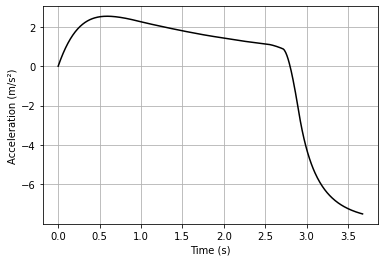

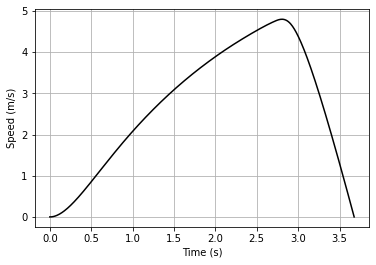

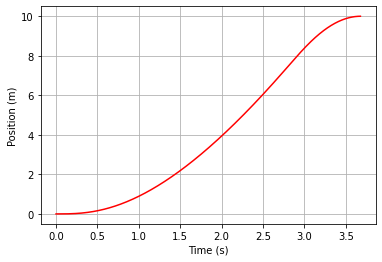

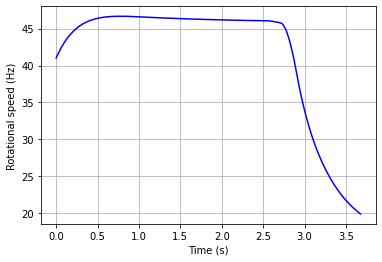

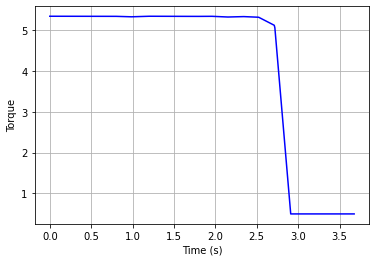

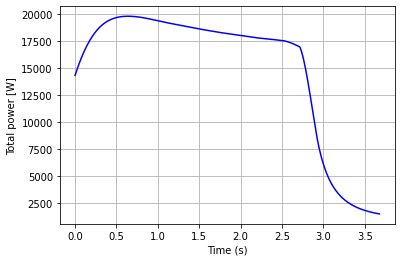

In [19]:
plot_trajectory(optim_problem.model.trajectory.trajectory.res)

In [20]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, 'problem_outputs.xml')

The `optimizer_viewer` offers a convenient summary of the optimization result:

In [21]:
api.optimization_viewer(CONFIGURATION_FILE)

You can use the `VariableViewer` tool to see the optimization results for all variables of the system by loading the .xml output file:

In [7]:
api.variable_viewer(OUTPUT_FILE)

In [22]:
import openmdao.api as om
from models.multirotor import Multirotor
prob = om.Problem()
prob.model = Multirotor()

prob.setup(check=True)

RuntimeError: <model> <class Multirotor>: Output name 'data:system:MTOW' refers to multiple outputs: ['mtow.data:system:MTOW', 'system_constraints.mtow.data:system:MTOW'].